MASSACHUSETTS INSTITUTE OF TECHNOLOGY<br>
SYSTEM DESIGN & MANAGEMENT<br>
Author: R. Chadwick Holmes<br>
Date: April 10, 2021<br>
Last Updated: December 9, 2021<br><br>

**Label: Final Workflow, Script 4**<br>
**Lowest Number of Features (based on Shapley)**<br>

Script Purpose:<br>
Script for exploring supervised learning applied to the data set and the impact of uncertainties.
<br><br>


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [ ]:
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install dataprep --no-binary dataprep
!pip install shap --no-binary shap

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import tree

from collections import Counter

import statsmodels.api as sm
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import pickle as pkl

import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import seaborn as sns

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Set seed for randomized elements in script

In [ ]:
seed = 43

# define extent for mapping
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
extent = [xmin,xmax,ymin,ymax]

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/Colab Notebooks/Data'

Mounted at /content/drive


### Load data from saved pickle file

In [ ]:
datafolder = Path(path) 

#with open(datafolder/ "wells_shared.pkl","rb") as handle:
with open(datafolder/ "wellsp4_shared.pkl","rb") as handle:
#with open(datafolder/ "wellsp8_shared.pkl","rb") as handle: 
    datadict = pkl.load(handle)
    
# unpack
fulldf = datadict['data']
coords = datadict['coords']
X_train = datadict['X_train'].reset_index(drop=True)
X_val   = datadict['X_val'].reset_index(drop=True)
X_test  = datadict['X_test'].reset_index(drop=True)
yr_train = datadict['yr_train'].reset_index(drop=True)
yr_val   = datadict['yr_val'].reset_index(drop=True)
yr_test  = datadict['yr_test'].reset_index(drop=True)
yc_train = datadict['yc_train'].reset_index(drop=True)
yc_val   = datadict['yc_val'].reset_index(drop=True)
yc_test  = datadict['yc_test'].reset_index(drop=True)

In [ ]:
print(X_train.shape)
X_train.head(2)

(2081, 26)


,DEM,DEMGrad,Gravity,GravityGrad,Magnetic,MagneticGrad,DosageRate,WTDepth,WTGrad,BasementDepth,CrustalThickness,AirTemperature,Precipitation,StrainRate,QFaults,StateFaults,Drainage,VolcanicDikes,SiGeothermometry,Lithium,Boron,HeatFlow,Earthquakes,Vents,Springs,GeothermGrad_2class
0,1295.000000,0.000950,-142.761505,0.105854,-176.388245,1.689665,54.990135,414.932678,101982.015625,3668.409912,27.983309,16.552637,250.675491,0.944725,12.385615,13.238408,3.962933,0.000000,46.190140,0.135530,0.509297,86.209236,-28.222088,-24.506508,-28.341091,"[0, 60)"
1,1280.403809,4.268405,-140.713547,0.053293,-130.635025,2.623726,63.302460,271.751038,598030.937500,4062.800293,27.660280,16.698074,265.794037,1.301721,5.504663,6.772988,7.627896,0.002682,80.419975,0.433037,0.349059,121.289711,-26.203899,-26.080971,-26.779902,"[60, 9999)"


In [ ]:
myprojection = ccrs.PlateCarree()

def createBasemap():
    expl_area = datafolder / 'Exploration_area.shp'
    expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

    rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
    #stamen_terrain = cimgt.Stamen('terrain-background')

    # generate plot of NM with river and stock image
    plt.figure(figsize=(20,12))
    ax = plt.axes(projection=myprojection)

    # Add the Stamen data at zoom level 9.
    ax.stock_img()
    #ax.add_image(stamen_terrain, 9)
    
    ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    ax.add_feature(expl_area_feat, facecolor='None', edgecolor='r', linewidth=2, alpha = 0.5)

    ax.set_extent(extent,crs=myprojection)
    
    return ax

## Test that plotting works

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


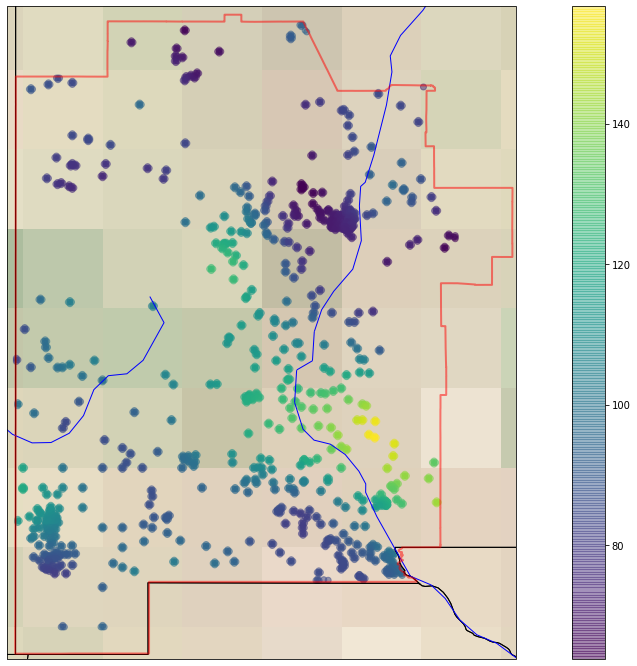

In [ ]:
ax = createBasemap();

gdf = gpd.GeoDataFrame(fulldf.copy(deep=True), 
                       geometry=gpd.points_from_xy(coords.Longitude, coords.Latitude),
                       crs = {'init': 'epsg:4326'})
pc = ax.scatter(coords.Longitude,
                coords.Latitude,
                cmap='viridis',
                c=gdf['HeatFlow'],
                #c=gdf['CutCategory'].cat.codes,
                #vmin=0, vmax=125,
                alpha=0.5,
                transform=myprojection);
plt.colorbar(pc);

### Data Prep

In [ ]:
## Set Plotting Parameters
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
list(X_train)

['DEM',
 'DEMGrad',
 'Gravity',
 'GravityGrad',
 'Magnetic',
 'MagneticGrad',
 'DosageRate',
 'WTDepth',
 'WTGrad',
 'BasementDepth',
 'CrustalThickness',
 'AirTemperature',
 'Precipitation',
 'StrainRate',
 'QFaults',
 'StateFaults',
 'Drainage',
 'VolcanicDikes',
 'SiGeothermometry',
 'Lithium',
 'Boron',
 'HeatFlow',
 'Earthquakes',
 'Vents',
 'Springs',
 'GeothermGrad_2class']

In [ ]:
rfe_cols = ['Gravity', 'Magnetic', 'RadiationDosage', 'StrainRate', 'QFaults', 'Drainage', 'VolcanicDikes', 'SiGeothermometry', 'Lithium', 'Boron', 'HeatFlow', 'Earthquakes', 'Vents', 'Springs']
# drop columns already determined to be colinear or are predicted variables
dropcols = ['AirTemperature','GeothermGrad_2class']
#dropcols = [x for x in X_train.columns if x not in rfe_cols]
print(dropcols)
Xtr = X_train.drop(dropcols,axis=1)
Xvl = X_val.drop(dropcols,axis=1)
Xts = X_test.drop(dropcols,axis=1)

# 4-class model 
yc_test4  = yc_test['GeothermGrad_4class'].cat.codes
yc_val4   = yc_val['GeothermGrad_4class'].cat.codes
yc_train4 = yc_train['GeothermGrad_4class'].cat.codes

# encode classification variable
le = LabelEncoder()
le.fit(yc_train4)
yenc_trn = le.transform(yc_train4)
yenc_val = le.transform(yc_val4)
yenc_tst = le.transform(yc_test4)

['AirTemperature', 'GeothermGrad_2class']


In [ ]:
# template for scaling and transforming data

# scale and transform data
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)
pl = Pipeline(steps=[('scale',sc),('powertransform',pt)])

colnames = list(Xtr.columns)
pl.fit(Xtr,yr_train)
Xtrsc = pd.DataFrame(pl.transform(Xtr), columns=colnames)
Xvlsc = pd.DataFrame(pl.transform(Xvl), columns=colnames)
Xtssc = pd.DataFrame(pl.transform(Xts), columns=colnames)

In [ ]:
print('train:')
counter = Counter(yc_train4)
for k,v in counter.items():
	per = v / len(yc_train4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
 
print('\nvalidate:')
counter = Counter(yc_val4)
for k,v in counter.items():
	per = v / len(yc_val4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

print('\ntest:')
counter = Counter(yc_test4)
for k,v in counter.items():
	per = v / len(yc_test4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
print()
print(list(Xtr))

train:
Class=2, n=801 (38.491%)
Class=3, n=860 (41.326%)
Class=1, n=349 (16.771%)
Class=0, n=71 (3.412%)

validate:
Class=2, n=171 (38.341%)
Class=3, n=185 (41.480%)
Class=1, n=75 (16.816%)
Class=0, n=15 (3.363%)

test:
Class=3, n=184 (41.256%)
Class=2, n=172 (38.565%)
Class=1, n=75 (16.816%)
Class=0, n=15 (3.363%)

['DEM', 'DEMGrad', 'Gravity', 'GravityGrad', 'Magnetic', 'MagneticGrad', 'DosageRate', 'WTDepth', 'WTGrad', 'BasementDepth', 'CrustalThickness', 'Precipitation', 'StrainRate', 'QFaults', 'StateFaults', 'Drainage', 'VolcanicDikes', 'SiGeothermometry', 'Lithium', 'Boron', 'HeatFlow', 'Earthquakes', 'Vents', 'Springs']


### XGBoosting Time!
####https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368

In [ ]:
import shap
import xgboost as xgb
print(xgb.__version__)
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

## adapted from
## https://github.com/ernestng11/touchpoint-prediction/blob/master/model-building.ipynb

# plot logloss and classification error after each iteration
def plot_compare(mets, eval_results, epochs):
  #print(eval_results)
  for m in mets:
    val_score = eval_results['val'][m]
    train_score = eval_results['train'][m]
    rang = range(0, epochs)
    plt.rcParams["figure.figsize"] = [6,6]
    plt.plot(rang, val_score,"c", label="Val")
    plt.plot(rang, train_score,"orange", label="Train")
    title_name = m + " plot"
    plt.title(title_name)
    plt.xlabel('Iterations')
    plt.ylabel(m)
    lgd = plt.legend()
    plt.show()

def XGBfit(model, 
           Xtrain, ytrain, 
           Xval, yval, 
           Xtest, ytest,
           predictors,
           savefig=False):

    xgb_param = model.get_xgb_params()
    mets = ['mlogloss','merror']
    xgb_param['eval_metric'] = mets
    xgb_param['num_class'] = len(np.unique(ytrain))
   
    xgtrain  = xgb.DMatrix(Xtrain[predictors].values, 
                           label=ytrain,
                           feature_names=predictors)
    xgval    = xgb.DMatrix(Xval[predictors].values,
                           label=yval,
                           feature_names=predictors)
    xgtest   = xgb.DMatrix(Xtest[predictors].values,
                           label=ytest,
                           feature_names=predictors)
    evallist = [(xgval, 'val'),(xgtrain, 'train')]

    store = {}
    xg_mod = xgb.train(xgb_param, xgtrain,
                       num_boost_round=model.get_params()['n_estimators'],
                       evals=evallist,
                       evals_result=store,
                       verbose_eval=100)       

    # predict
    predprobs = xg_mod.predict(xgtrain)
    preds     = np.argmax(predprobs, axis=1)
    predprobs_test = xg_mod.predict(xgtest)
    preds_test = np.argmax(predprobs_test, axis=1)

    # print stats
    print("\nXGBFit Results")
    print("Accuracy (Train) : %.4g" % metrics.accuracy_score(ytrain, preds))
    print("Accuracy (Test)  : %.4g" % metrics.accuracy_score(ytest, preds_test))
    print("F1-weighted (Train): %f" % metrics.f1_score(ytrain, preds, average='weighted'))
    print("F1-weighted (Test) : %f" % metrics.f1_score(ytest, preds_test,average='weighted'))
    print("macro AUC (Train): %f" % metrics.roc_auc_score(ytrain, predprobs, average='macro', multi_class='ovr'))
    print("weighted AUC (Train): %f" % metrics.roc_auc_score(ytrain, predprobs, average='weighted', multi_class='ovr'))
    print("macro AUC (Test) : %f" % metrics.roc_auc_score(ytest, predprobs_test, average='macro', multi_class='ovr'))
    print("weighted AUC (Test): %f" % metrics.roc_auc_score(ytest, predprobs_test, average='weighted', multi_class='ovr'))

    # print confusion matrix
    confusion = confusion_matrix(ytest, preds_test)
    print(confusion)
    print(classification_report(ytest, preds_test, 
                                target_names=['No-GT','Low-GT','Med-GT','High-GT']))

    with mpl.style.context('default'):
      df_cm = pd.DataFrame(confusion, range(4), range(4))
      sns.set(font_scale=1.4) # for label size
      sns.heatmap(df_cm, cmap='viridis',vmax=40,annot=True, 
                fmt='g', annot_kws={"size": 16}) # font size
      plt.xlabel('Predicted')
      ax = plt.gca()
      ax.xaxis.set_label_position('top') 
      plt.ylabel('Actual Class',labelpad=5)
      ax.xaxis.tick_top()
      ax.yaxis.tick_left()

      if(savefig):  
        plt.savefig(datafolder / 'XGBoost_WDS4_ConfusionMatrix.png', bbox_inches='tight')
      plt.show()

    # plot training plots
    plot_compare(mets, store, xgb_param['n_estimators'])

    # plot feature importances
    f, ax = plt.subplots(figsize=(10,5))

    fimport = pd.Series(xg_mod.get_fscore())
    fimport = fimport.sort_values(ascending=False)
    plot = sns.barplot(fimport.index,fimport.values)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()

    # move booster back into scikit XGBClassifier
    model._Booster = xg_mod

    xgb.plot_importance(model)
    
    return model

0.90


In [ ]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

### Run without tuning

In [ ]:
LR    = 0.01
NEST  = 200
MAXD  = 5
MINCW = 1
GAMMA = 0.2
SSBT, CSBT = 1., 1.
LAMBDA = 1.0
SPWT  = 1.0  # tune later: class imbalance

best_params = {}

In [ ]:
print(Xtrsc.shape, yenc_trn.shape, Xvlsc.shape, yenc_val.shape, Xtssc.shape, yenc_tst.shape)

(2081, 24) (2081,) (446, 24) (446,) (446, 24) (446,)


[0]	val-mlogloss:1.37453	val-merror:0.172646	train-mlogloss:1.37408	train-merror:0.146564
[100]	val-mlogloss:0.709651	val-merror:0.098655	train-mlogloss:0.686074	train-merror:0.076886
[199]	val-mlogloss:0.459829	val-merror:0.076233	train-mlogloss:0.422003	train-merror:0.059106

XGBFit Results
Accuracy (Train) : 0.9409
Accuracy (Test)  : 0.8969
F1-weighted (Train): 0.940389
F1-weighted (Test) : 0.895317
macro AUC (Train): 0.995221
weighted AUC (Train): 0.993534
macro AUC (Test) : 0.987407
weighted AUC (Test): 0.984524
[[ 10   5   0   0]
 [  0  59  10   6]
 [  0   2 155  15]
 [  0   0   8 176]]
              precision    recall  f1-score   support

       No-GT       1.00      0.67      0.80        15
      Low-GT       0.89      0.79      0.84        75
      Med-GT       0.90      0.90      0.90       172
     High-GT       0.89      0.96      0.92       184

    accuracy                           0.90       446
   macro avg       0.92      0.83      0.86       446
weighted avg       0

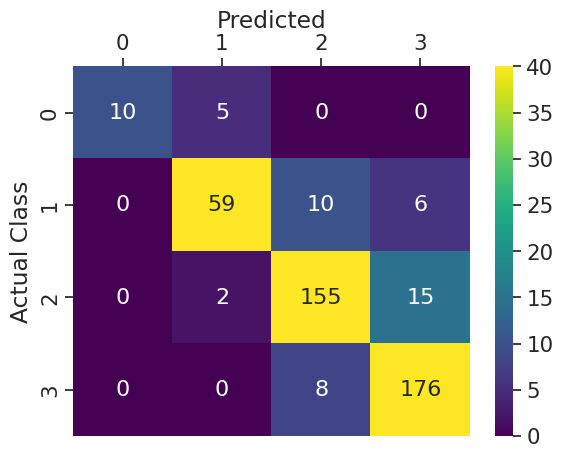

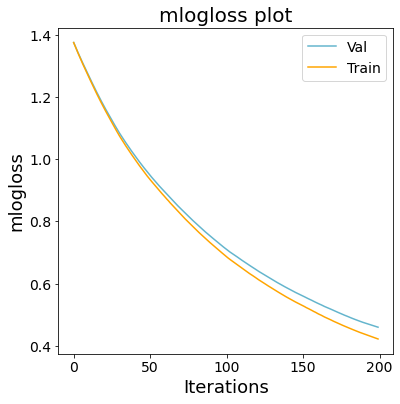

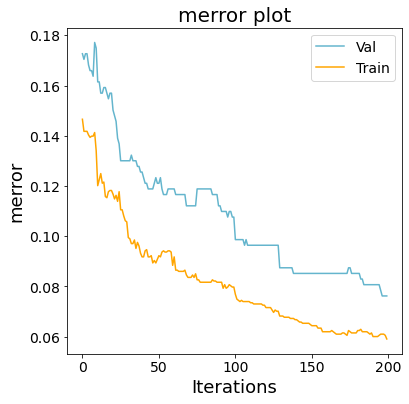

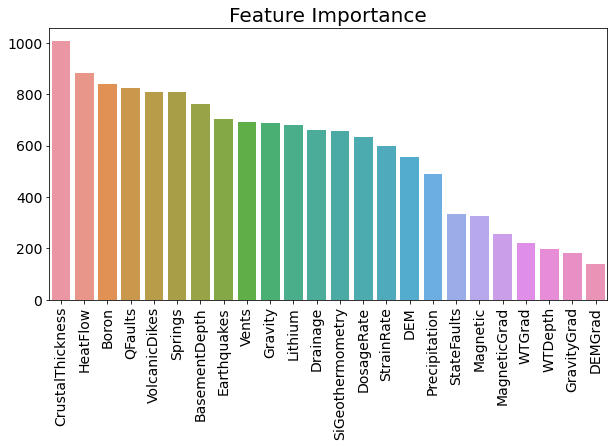

XGBClassifier(colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5,
              n_estimators=200, n_jobs=-1, objective='multi:softprob',
              reg_lambda=1.0, scale_pos_weight=1.0, seed=43, subsample=1.0)


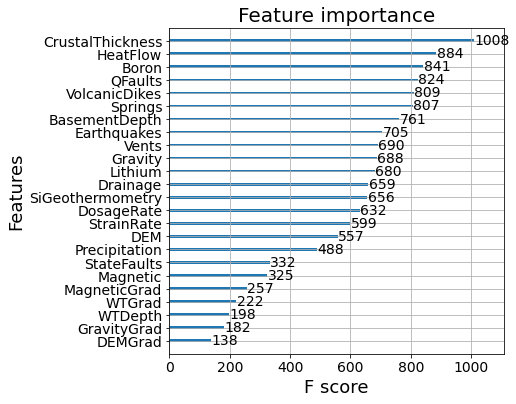

In [ ]:
# First Run, Untuned 

#Choose all predictors except target & IDcols
keepcols = [x for x in Xtr.columns if x not in dropcols]
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

xgb_model = XGBfit(xgb_model, 
                   Xtrsc, pd.Series(yenc_trn,name='GeothermGrad'), 
                   Xvlsc, pd.Series(yenc_val,name='GeothermGrad'), 
                   Xtssc, pd.Series(yenc_tst,name='GeothermGrad'), 
                   keepcols);
print(xgb_model)

### Create combination train + validate set

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib as mpl

Xtrvl = pd.concat([Xtr[colnames],Xvl[colnames]])
Xtrnvalsc=pd.concat([Xtrsc[colnames],Xvlsc[colnames]])
yenc_trnval=np.append(yenc_trn,yenc_val)

### Tune on max_depth

In [ ]:
# Tuning of max_depth

valrng = range(1,16,1)
params_gs1 = {
  'max_depth':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv1 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs1,
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose=10,
                       cv=cv)
gridcv1 = gridcv1.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['max_depth'] = gridcv1.best_params_['max_depth']
MAXD = best_params['max_depth']

getTrainScores(gridcv1)

Fitting 30 folds for each of 15 candidates, totalling 450 fits


({0: "mean:0.8157715429428248params{'max_depth': 1}",
  1: "mean:0.904167414109702params{'max_depth': 2}",
  2: "mean:0.9433855736058913params{'max_depth': 3}",
  3: "mean:0.9655973701176216params{'max_depth': 4}",
  4: "mean:0.9781476004121978params{'max_depth': 5}",
  5: "mean:0.983517314701579params{'max_depth': 6}",
  6: "mean:0.9845938375627282params{'max_depth': 7}",
  7: "mean:0.9851226576428922params{'max_depth': 8}",
  8: "mean:0.9866009734660734params{'max_depth': 9}",
  9: "mean:0.9867549782819154params{'max_depth': 10}",
  10: "mean:0.9866815256775738params{'max_depth': 11}",
  11: "mean:0.9871075652680309params{'max_depth': 12}",
  12: "mean:0.9873669967845107params{'max_depth': 13}",
  13: "mean:0.9875301516092977params{'max_depth': 14}",
  14: "mean:0.9876951529055744params{'max_depth': 15}"},
 {'best_mean': 0.9876951529055744, 'best_param': {'max_depth': 15}})

#### plot for thesis figure

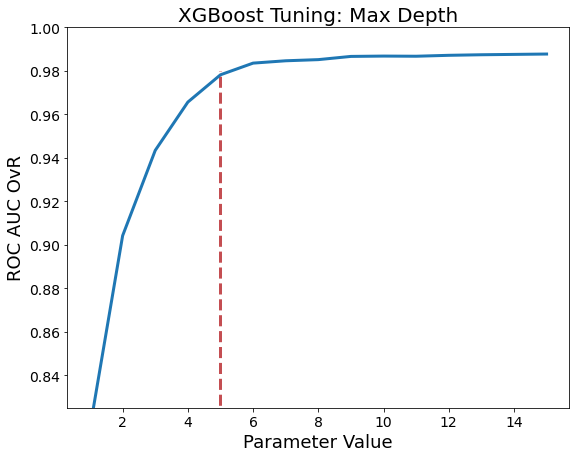

In [ ]:
gridcv1.cv_results_['mean_test_score']
cv = gridcv1

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',lw=3)
  plt.vlines(5,#best_params['max_depth'],
             ymin=0.0,ymax=0.9798,
             linestyles='dashed',colors='r',lw=3)
  plt.ylim([0.825,1])
  #plt.legend(loc='lower right')
  plt.title('XGBoost Tuning: Max Depth');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

best_params['max_depth'] = MAXD = 5

[0]	val-mlogloss:1.37453	val-merror:0.172646	train-mlogloss:1.37408	train-merror:0.146564
[100]	val-mlogloss:0.709651	val-merror:0.098655	train-mlogloss:0.686074	train-merror:0.076886
[199]	val-mlogloss:0.459829	val-merror:0.076233	train-mlogloss:0.422003	train-merror:0.059106

XGBFit Results
Accuracy (Train) : 0.9409
Accuracy (Test)  : 0.8969
F1-weighted (Train): 0.940389
F1-weighted (Test) : 0.895317
macro AUC (Train): 0.995221
weighted AUC (Train): 0.993534
macro AUC (Test) : 0.987407
weighted AUC (Test): 0.984524
[[ 10   5   0   0]
 [  0  59  10   6]
 [  0   2 155  15]
 [  0   0   8 176]]
              precision    recall  f1-score   support

       No-GT       1.00      0.67      0.80        15
      Low-GT       0.89      0.79      0.84        75
      Med-GT       0.90      0.90      0.90       172
     High-GT       0.89      0.96      0.92       184

    accuracy                           0.90       446
   macro avg       0.92      0.83      0.86       446
weighted avg       0

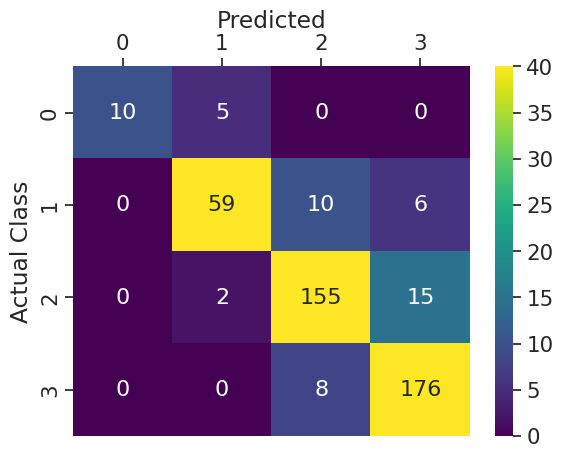

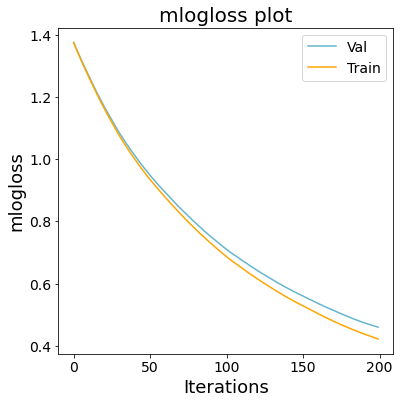

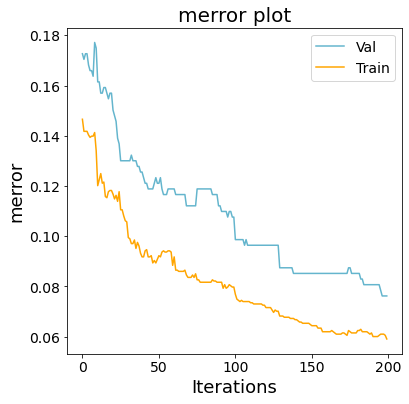

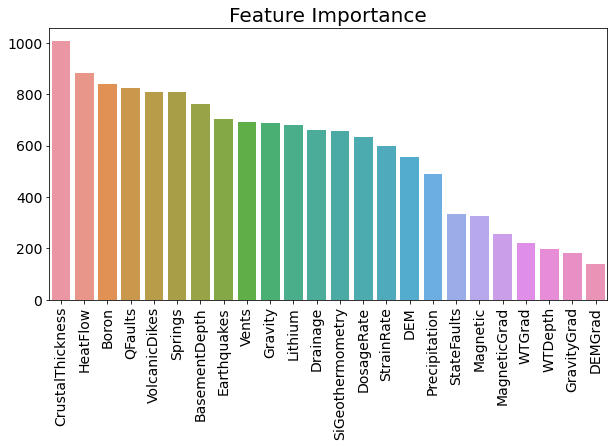

XGBClassifier(colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5,
              n_estimators=200, n_jobs=-1, objective='multi:softprob',
              reg_lambda=1.0, scale_pos_weight=1.0, seed=43, subsample=1.0)


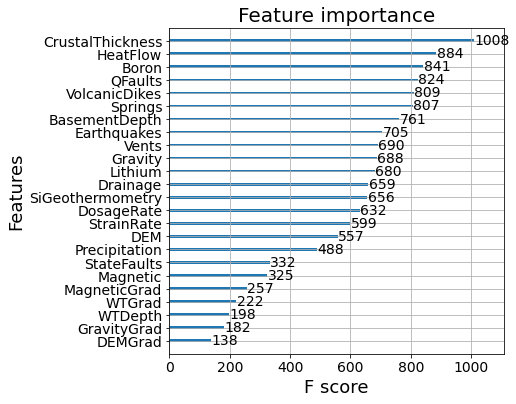

In [ ]:
# Incorporate tuning results 
xgb_model2 = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1, 
                          scale_pos_weight=SPWT, 
                          seed=seed)

xgb_model2 = XGBfit(xgb_model2,
                    Xtrsc, 
                    pd.Series(yenc_trn,name='GeothermGrad'),  
                    Xvlsc, 
                    pd.Series(yenc_val,name='GeothermGrad'), 
                    Xtssc, 
                    pd.Series(yenc_tst,name='GeothermGrad'), 
                    keepcols);
print(xgb_model2)

### Tune on min_child_weight

In [ ]:
# Tuning of min_child_weight

valrng = range(1,11,1)
params_gs2 = {
  'min_child_weight':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv2 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs2, 
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose=10,
                       cv=cv)
gridcv2 = gridcv2.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['min_child_weight'] = gridcv2.best_params_['min_child_weight']
MINCW = best_params['min_child_weight']

getTrainScores(gridcv2)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


({0: "mean:0.9781476004121978params{'min_child_weight': 1}",
  1: "mean:0.977595802906233params{'min_child_weight': 2}",
  2: "mean:0.9778383092066513params{'min_child_weight': 3}",
  3: "mean:0.9763336618237037params{'min_child_weight': 4}",
  4: "mean:0.9762317735230506params{'min_child_weight': 5}",
  5: "mean:0.9749403278704512params{'min_child_weight': 6}",
  6: "mean:0.9742786425547394params{'min_child_weight': 7}",
  7: "mean:0.9735844035846086params{'min_child_weight': 8}",
  8: "mean:0.9722672760750607params{'min_child_weight': 9}",
  9: "mean:0.9718835194660967params{'min_child_weight': 10}"},
 {'best_mean': 0.9781476004121978, 'best_param': {'min_child_weight': 1}})

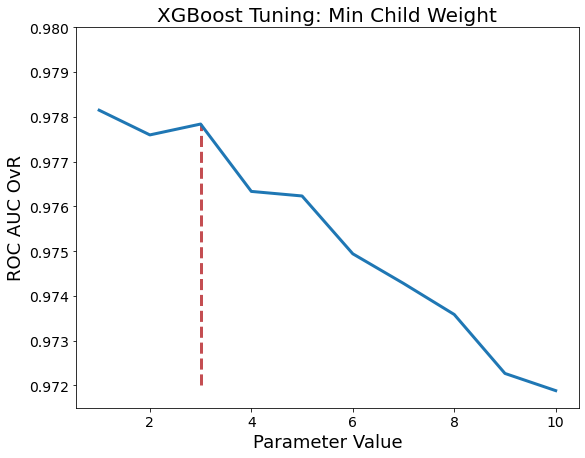

In [ ]:
best_params['min_child_weight'] = MINCW = 3

cv = gridcv2
with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',lw=3)
  plt.vlines(best_params['min_child_weight'],
             ymin=0.972,ymax=0.97785,
             linestyles='dashed',colors='r',lw=3)
  plt.ylim([0.9715,0.98])#0.9875])
  plt.title('XGBoost Tuning: Min Child Weight');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

[0]	val-mlogloss:1.37475	val-merror:0.17713	train-mlogloss:1.37422	train-merror:0.148006
[100]	val-mlogloss:0.723124	val-merror:0.125561	train-mlogloss:0.696077	train-merror:0.086497
[199]	val-mlogloss:0.480383	val-merror:0.091928	train-mlogloss:0.441606	train-merror:0.069678

XGBFit Results
Accuracy (Train) : 0.9303
Accuracy (Test)  : 0.9058
F1-weighted (Train): 0.929636
F1-weighted (Test) : 0.904480
macro AUC (Train): 0.993282
weighted AUC (Train): 0.991419
macro AUC (Test) : 0.983842
weighted AUC (Test): 0.984167
[[ 13   2   0   0]
 [  0  57  12   6]
 [  0   4 157  11]
 [  0   0   7 177]]
              precision    recall  f1-score   support

       No-GT       1.00      0.87      0.93        15
      Low-GT       0.90      0.76      0.83        75
      Med-GT       0.89      0.91      0.90       172
     High-GT       0.91      0.96      0.94       184

    accuracy                           0.91       446
   macro avg       0.93      0.88      0.90       446
weighted avg       0.

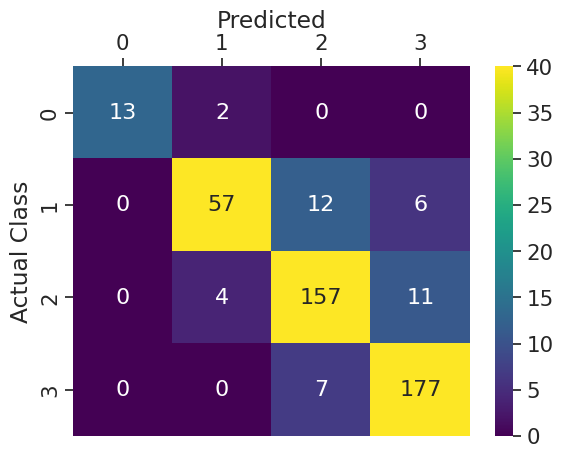

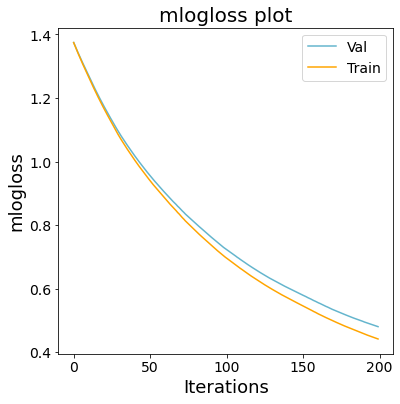

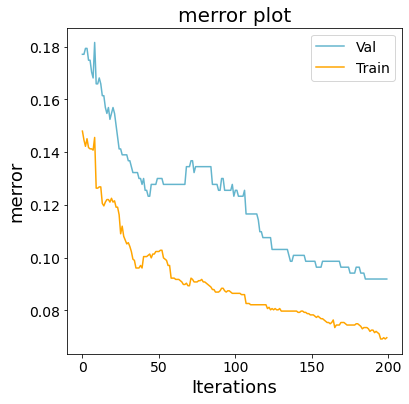

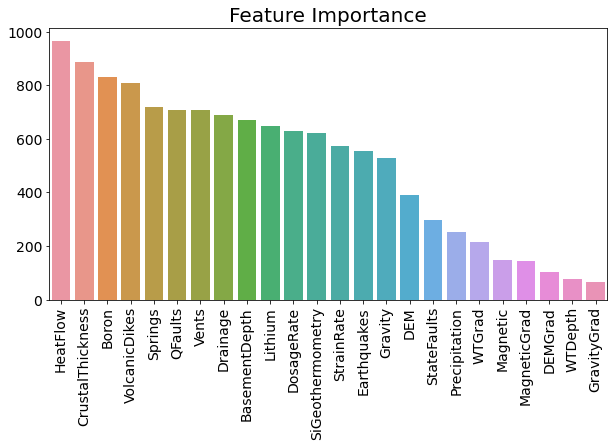

XGBClassifier(colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5,
              min_child_weight=3, n_estimators=200, n_jobs=-1,
              objective='multi:softprob', reg_lambda=1.0, scale_pos_weight=1.0,
              seed=43, subsample=1.0)


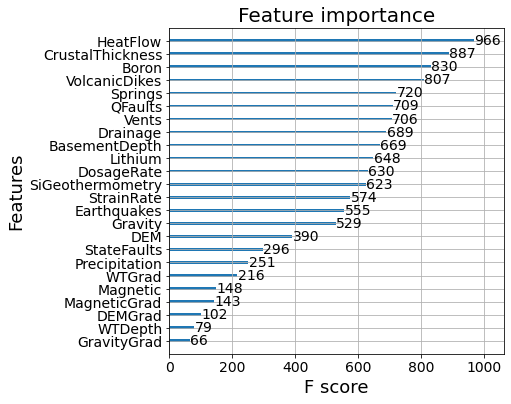

In [ ]:
# Incorporate tuning results
xgb_model3 = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1, 
                          scale_pos_weight=SPWT, 
                          seed=seed)

xgb_model3 = XGBfit(xgb_model3,
                    Xtrsc, 
                    pd.Series(yenc_trn,name='GeothermGrad'),  
                    Xvlsc, 
                    pd.Series(yenc_val,name='GeothermGrad'), 
                    Xtssc, 
                    pd.Series(yenc_tst,name='GeothermGrad'), 
                    keepcols);
print(xgb_model3)

### Tune on gamma

In [ ]:
# Tuning of gamma

valrng = [i/10. for i in range(0,11)]
params_gs3 = {
 'gamma':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv3 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs3, 
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose = 10,
                       cv=cv)

gridcv3 = gridcv3.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['gamma'] = GAMMA = gridcv3.best_params_['gamma']

getTrainScores(gridcv3)

Fitting 30 folds for each of 11 candidates, totalling 330 fits


({0: "mean:0.9779564724326542params{'gamma': 0.0}",
  1: "mean:0.9779744287153013params{'gamma': 0.1}",
  2: "mean:0.9778383092066513params{'gamma': 0.2}",
  3: "mean:0.97789271481624params{'gamma': 0.3}",
  4: "mean:0.9778785018680974params{'gamma': 0.4}",
  5: "mean:0.9778630582626545params{'gamma': 0.5}",
  6: "mean:0.977728313802533params{'gamma': 0.6}",
  7: "mean:0.977759493250145params{'gamma': 0.7}",
  8: "mean:0.9778871183739638params{'gamma': 0.8}",
  9: "mean:0.9779277280534987params{'gamma': 0.9}",
  10: "mean:0.9778058777755343params{'gamma': 1.0}"},
 {'best_mean': 0.9779744287153013, 'best_param': {'gamma': 0.1}})

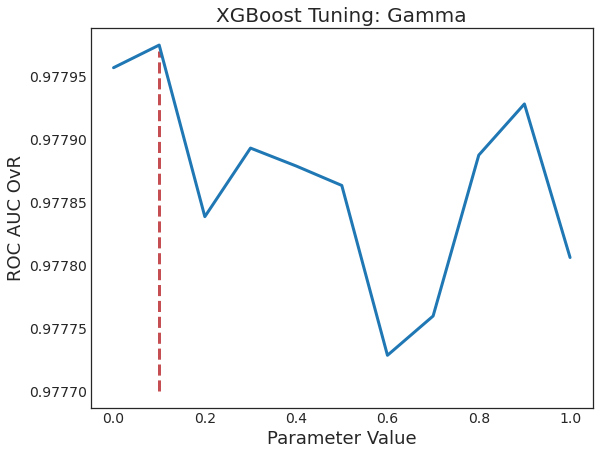

In [ ]:
cv = gridcv3

# WDS4
#best_params['gamma'] = GAMMA = 0.1

# WDS, WDS8
#best_params['gamma'] = GAMMA = 0.5

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',lw=3)
  plt.vlines(best_params['gamma'],
             ymin=0.9777,ymax=0.97797,
             linestyles='dashed',colors='r',lw=3)
  plt.title('XGBoost Tuning: Gamma');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

[0]	val-mlogloss:1.37474	val-merror:0.17713	train-mlogloss:1.37422	train-merror:0.148006
[100]	val-mlogloss:0.722611	val-merror:0.127803	train-mlogloss:0.696044	train-merror:0.087458
[199]	val-mlogloss:0.479393	val-merror:0.091928	train-mlogloss:0.440809	train-merror:0.069197

XGBFit Results
Accuracy (Train) : 0.9308
Accuracy (Test)  : 0.9013
F1-weighted (Train): 0.930147
F1-weighted (Test) : 0.899999
macro AUC (Train): 0.993410
weighted AUC (Train): 0.991496
macro AUC (Test) : 0.984205
weighted AUC (Test): 0.984214
[[ 13   2   0   0]
 [  0  57  12   6]
 [  0   4 155  13]
 [  0   0   7 177]]
              precision    recall  f1-score   support

       No-GT       1.00      0.87      0.93        15
      Low-GT       0.90      0.76      0.83        75
      Med-GT       0.89      0.90      0.90       172
     High-GT       0.90      0.96      0.93       184

    accuracy                           0.90       446
   macro avg       0.92      0.87      0.90       446
weighted avg       0.

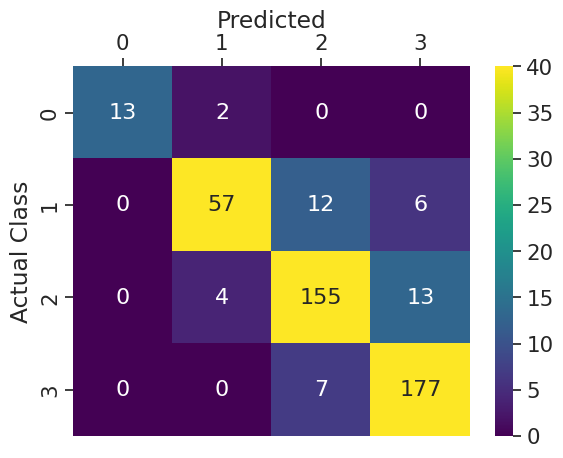

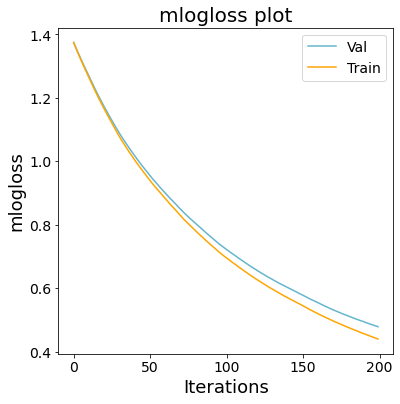

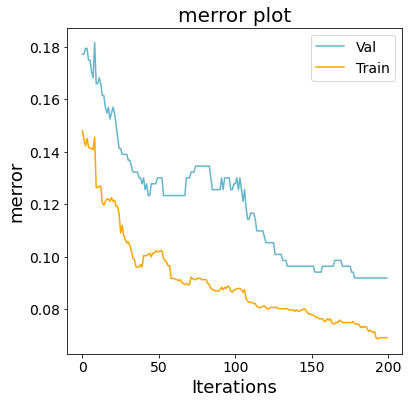

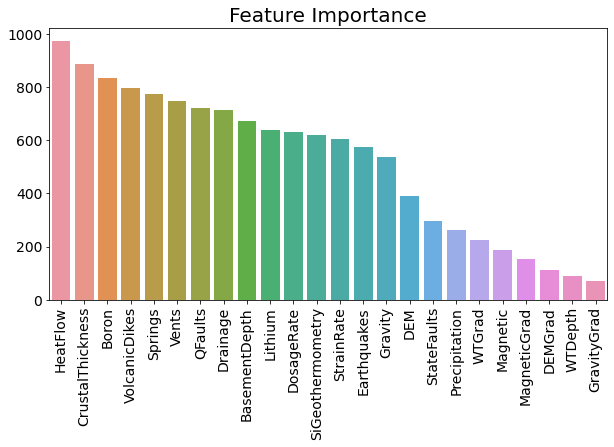

XGBClassifier(colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5,
              min_child_weight=3, n_estimators=200, n_jobs=-1,
              objective='multi:softprob', reg_lambda=1.0, scale_pos_weight=1.0,
              seed=43, subsample=1.0)


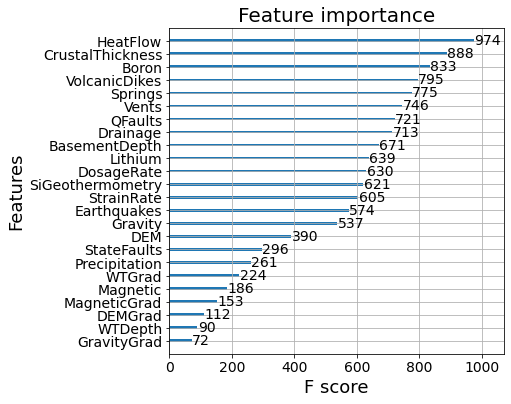

In [ ]:
# Incorporate tuning results
xgb_model4 = XGBClassifier(learning_rate=LR,
                           n_estimators=NEST, 
                           max_depth=MAXD, 
                           min_child_weight=MINCW,
                           gamma=GAMMA, 
                           subsample=SSBT, 
                           colsample_bytree=CSBT,
                           reg_lambda=LAMBDA,
                           objective='multi:softprob',
                           n_jobs=-1, 
                           scale_pos_weight=SPWT, 
                           seed=seed)

xgb_model4 = XGBfit(xgb_model4, 
                    Xtrsc, 
                    pd.Series(yenc_trn,name='GeothermGrad'), 
                    Xvlsc, 
                    pd.Series(yenc_val,name='GeothermGrad'), 
                    Xtssc, 
                    pd.Series(yenc_tst,name='GeothermGrad'), 
                    keepcols);
print(xgb_model4)

### Tune on subsample and colsample_bytree

In [ ]:
# Tuning of subsample, colsample_bytree
valrng = [i/10.0 for i in range(1,11)]
params_gs4 = {
  'subsample':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv4 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs4, 
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose = 10,
                       cv=cv)

gridcv4 = gridcv4.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['subsample'] = SSBT = gridcv4.best_params_['subsample']

getTrainScores(gridcv4)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


({0: "mean:0.9620810335128716params{'subsample': 0.1}",
  1: "mean:0.9750840475705925params{'subsample': 0.2}",
  2: "mean:0.9794276662782323params{'subsample': 0.3}",
  3: "mean:0.9808301259409216params{'subsample': 0.4}",
  4: "mean:0.9814769128909486params{'subsample': 0.5}",
  5: "mean:0.9821392042969317params{'subsample': 0.6}",
  6: "mean:0.9820045248363873params{'subsample': 0.7}",
  7: "mean:0.9813107558843094params{'subsample': 0.8}",
  8: "mean:0.9805943004373143params{'subsample': 0.9}",
  9: "mean:0.9779744287153013params{'subsample': 1.0}"},
 {'best_mean': 0.9821392042969317, 'best_param': {'subsample': 0.6}})

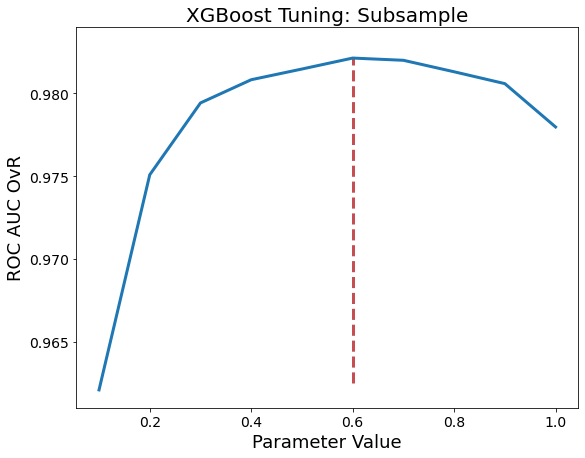

In [ ]:
cv = gridcv4

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',lw=3)
  plt.vlines(best_params['subsample'],
             ymin=0.9625,ymax=cv.best_score_,
             linestyles='dashed',colors='r',lw=3)
  plt.ylim([0.961,0.984])
  plt.title('XGBoost Tuning: Subsample');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

In [ ]:
# Tuning of subsample, colsample_bytree
valrng = [i/10.0 for i in range(1,11)]
params_gs5 = {
  'colsample_bytree':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv5 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs5, 
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose = 10,
                       cv=cv)

gridcv5 = gridcv5.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['colsample_bytree'] = CSBT = gridcv5.best_params_['colsample_bytree']

getTrainScores(gridcv5)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


({0: "mean:0.9754567133297486params{'colsample_bytree': 0.1}",
  1: "mean:0.9817753850478699params{'colsample_bytree': 0.2}",
  2: "mean:0.9834407373325884params{'colsample_bytree': 0.3}",
  3: "mean:0.9837868542370632params{'colsample_bytree': 0.4}",
  4: "mean:0.9838749729981162params{'colsample_bytree': 0.5}",
  5: "mean:0.9838632947115912params{'colsample_bytree': 0.6}",
  6: "mean:0.9838472384169016params{'colsample_bytree': 0.7}",
  7: "mean:0.9833764822619079params{'colsample_bytree': 0.8}",
  8: "mean:0.9830202128540064params{'colsample_bytree': 0.9}",
  9: "mean:0.9821392042969317params{'colsample_bytree': 1.0}"},
 {'best_mean': 0.9838749729981162, 'best_param': {'colsample_bytree': 0.5}})

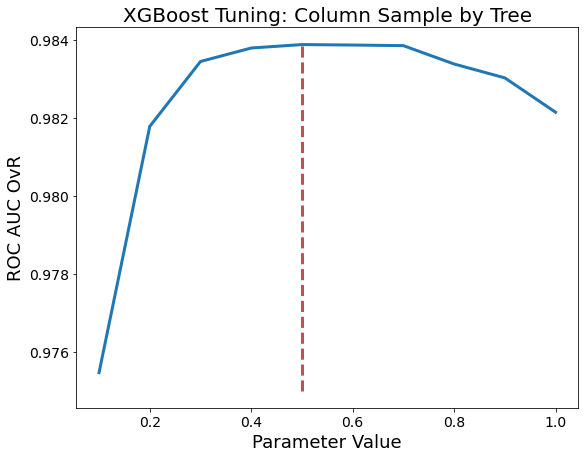

In [ ]:
cv = gridcv5

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',lw=3)
  plt.vlines(best_params['colsample_bytree'],
             ymin=0.975,ymax=cv.best_score_,
             linestyles='dashed',colors='r',lw=3)
  #plt.ylim([0.987,0.9895])
  plt.title('XGBoost Tuning: Column Sample by Tree');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

[0]	val-mlogloss:1.37611	val-merror:0.221973	train-mlogloss:1.37602	train-merror:0.221528
[100]	val-mlogloss:0.755726	val-merror:0.103139	train-mlogloss:0.732155	train-merror:0.082653
[199]	val-mlogloss:0.517381	val-merror:0.089686	train-mlogloss:0.478312	train-merror:0.058145

XGBFit Results
Accuracy (Train) : 0.9419
Accuracy (Test)  : 0.9036
F1-weighted (Train): 0.941004
F1-weighted (Test) : 0.902339
macro AUC (Train): 0.994673
weighted AUC (Train): 0.992841
macro AUC (Test) : 0.990008
weighted AUC (Test): 0.987956
[[ 11   4   0   0]
 [  0  59   9   7]
 [  0   5 156  11]
 [  0   0   7 177]]
              precision    recall  f1-score   support

       No-GT       1.00      0.73      0.85        15
      Low-GT       0.87      0.79      0.83        75
      Med-GT       0.91      0.91      0.91       172
     High-GT       0.91      0.96      0.93       184

    accuracy                           0.90       446
   macro avg       0.92      0.85      0.88       446
weighted avg       0

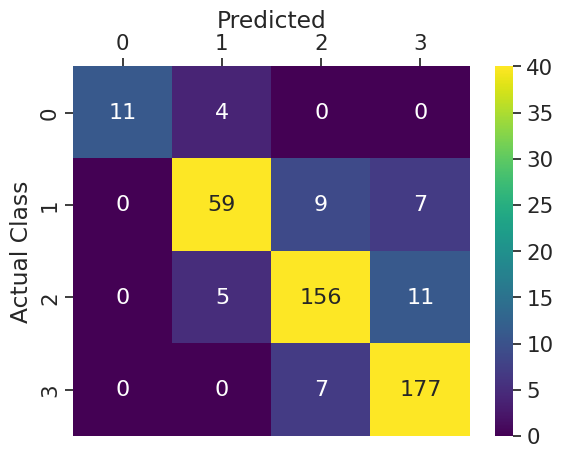

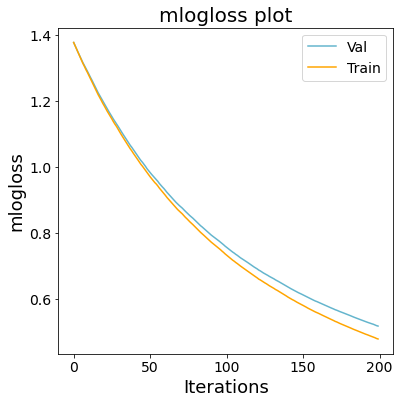

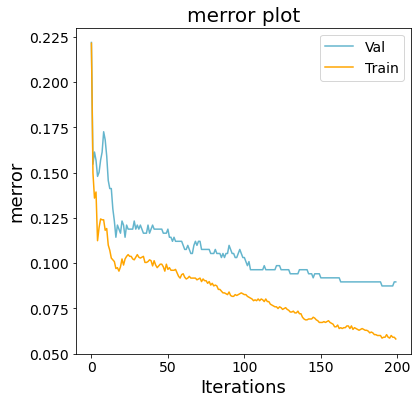

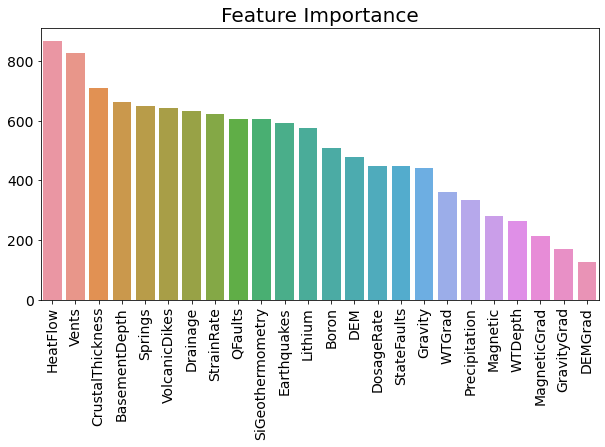

XGBClassifier(colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5,
              min_child_weight=3, n_estimators=200, n_jobs=-1,
              objective='multi:softprob', reg_lambda=1.0, scale_pos_weight=1.0,
              seed=43, subsample=0.6)


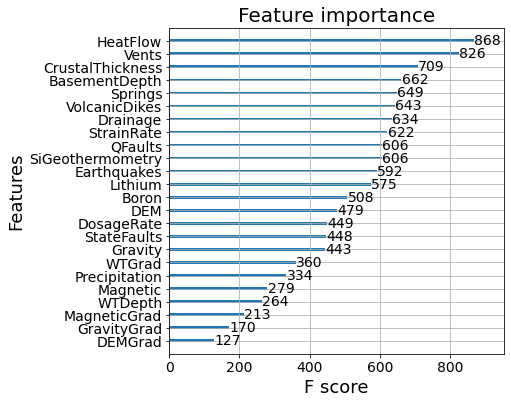

In [ ]:
# Incorporate tuning results
xgb_model5 = XGBClassifier(learning_rate=LR,
                           n_estimators=NEST, 
                           max_depth=MAXD, 
                           min_child_weight=MINCW,
                           gamma=GAMMA, 
                           subsample=SSBT, 
                           colsample_bytree=CSBT,
                           reg_lambda=LAMBDA,
                           objective='multi:softprob',
                           n_jobs=-1, 
                           scale_pos_weight=SPWT, 
                           seed=seed)

xgb_model5 = XGBfit(xgb_model5, 
                    Xtrsc, 
                    pd.Series(yenc_trn,name='GeothermGrad'), 
                    Xvlsc, 
                    pd.Series(yenc_val,name='GeothermGrad'), 
                    Xtssc, 
                    pd.Series(yenc_tst,name='GeothermGrad'), 
                    keepcols);
print(xgb_model5)

#### Test joint search = same result

In [ ]:
# Tuning of subsample, colsample_bytree
valrng = [i/10.0 for i in range(1,11)]
params_gs7 = {
  'subsample':valrng,
  'colsample_bytree':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv7 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs7, 
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose = 10,
                       cv=cv)

gridcv7 = gridcv7.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
#best_params['subsample'] = SSBT = gridcv5.best_params_['subsample']
#best_params['colsample_bytree'] = CSBT = gridcv5.best_params_['colsample_bytree']

getTrainScores(gridcv7)

#### Tune on Lambda

In [ ]:
# Tuning of lambda

valrng = np.logspace(-10,2,20)
params_gs8 = {
  'reg_lambda':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=best_params['max_depth'], 
                          min_child_weight=best_params['min_child_weight'],
                          gamma=best_params['gamma'], 
                          subsample=best_params['subsample'], 
                          colsample_bytree=best_params['colsample_bytree'],
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv8 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs8,
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose = 10,
                       cv=cv)

gridcv8 = gridcv8.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['reg_lambda'] = LAMBDA = gridcv8.best_params_['reg_lambda']

getTrainScores(gridcv8)

Fitting 30 folds for each of 20 candidates, totalling 600 fits


({0: "mean:0.9847601264083543params{'reg_lambda': 1e-10}",
  1: "mean:0.9847601264083543params{'reg_lambda': 4.281332398719396e-10}",
  2: "mean:0.9847601264083543params{'reg_lambda': 1.8329807108324374e-09}",
  3: "mean:0.9847601264083543params{'reg_lambda': 7.847599703514623e-09}",
  4: "mean:0.9847601264083543params{'reg_lambda': 3.3598182862837814e-08}",
  5: "mean:0.9847601264083543params{'reg_lambda': 1.438449888287663e-07}",
  6: "mean:0.9847601264083543params{'reg_lambda': 6.158482110660254e-07}",
  7: "mean:0.9847474003743469params{'reg_lambda': 2.6366508987303555e-06}",
  8: "mean:0.9847458804029363params{'reg_lambda': 1.1288378916846883e-05}",
  9: "mean:0.9847458675474506params{'reg_lambda': 4.8329302385717524e-05}",
  10: "mean:0.9847512097666142params{'reg_lambda': 0.00020691380811147902}",
  11: "mean:0.9847528030955587params{'reg_lambda': 0.0008858667904100814}",
  12: "mean:0.984764418570086params{'reg_lambda': 0.003792690190732246}",
  13: "mean:0.9847139626423347para

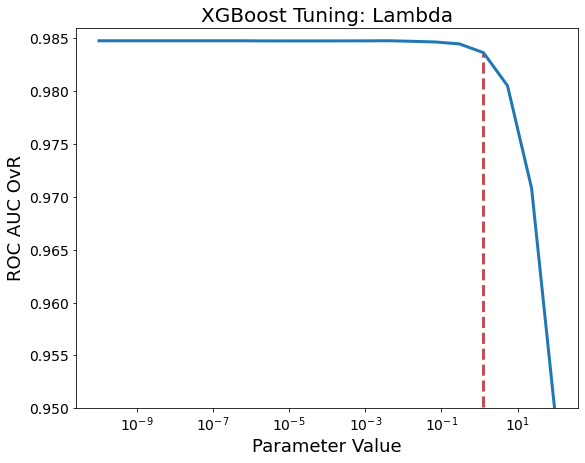

In [ ]:
cv = gridcv8

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',lw=3)
  plt.vlines(1.2742749857031321,#best_params['reg_lambda'],
             ymin=0.92,ymax=0.9836,#ymax=cv.best_score_,
             linestyles='dashed',colors='r',lw=3)
  plt.ylim([0.95,0.986])
  plt.title('XGBoost Tuning: Lambda');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');
  
  plt.gca().set_xscale('log')

# WDS4
best_params['reg_lambda'] = LAMBDA = 1.2742749857031321

# WDS
#best_params['reg_lambda'] = LAMBDA = 0.2976351441631313

# WDS8
#best_params['reg_lambda'] = LAMBDA = 1.2742749857031321

[0]	val-mlogloss:1.37621	val-merror:0.219731	train-mlogloss:1.37613	train-merror:0.222009
[100]	val-mlogloss:0.758236	val-merror:0.100897	train-mlogloss:0.734863	train-merror:0.082653
[199]	val-mlogloss:0.519107	val-merror:0.089686	train-mlogloss:0.480536	train-merror:0.058626

XGBFit Results
Accuracy (Train) : 0.9414
Accuracy (Test)  : 0.9058
F1-weighted (Train): 0.940534
F1-weighted (Test) : 0.904516
macro AUC (Train): 0.994591
weighted AUC (Train): 0.992755
macro AUC (Test) : 0.989919
weighted AUC (Test): 0.987971
[[ 11   4   0   0]
 [  0  59   9   7]
 [  0   5 156  11]
 [  0   0   6 178]]
              precision    recall  f1-score   support

       No-GT       1.00      0.73      0.85        15
      Low-GT       0.87      0.79      0.83        75
      Med-GT       0.91      0.91      0.91       172
     High-GT       0.91      0.97      0.94       184

    accuracy                           0.91       446
   macro avg       0.92      0.85      0.88       446
weighted avg       0

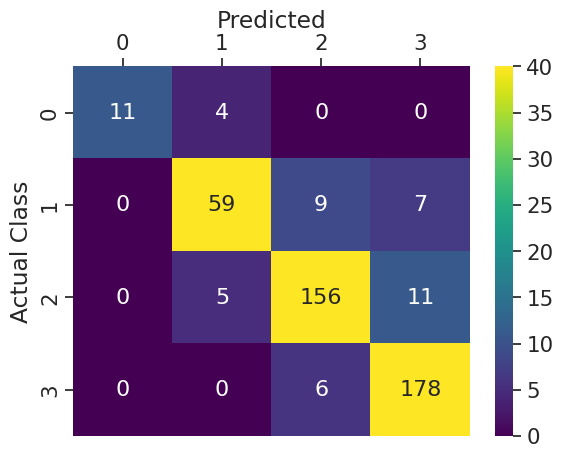

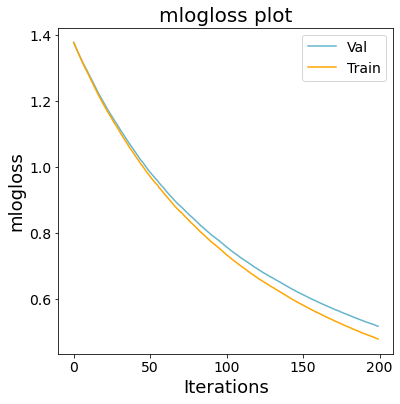

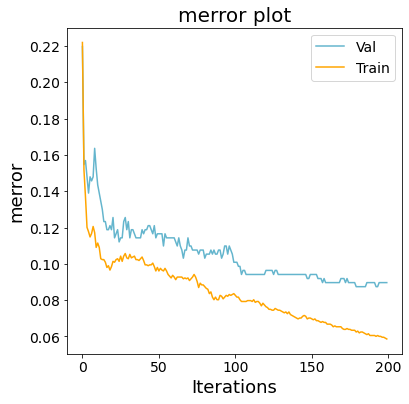

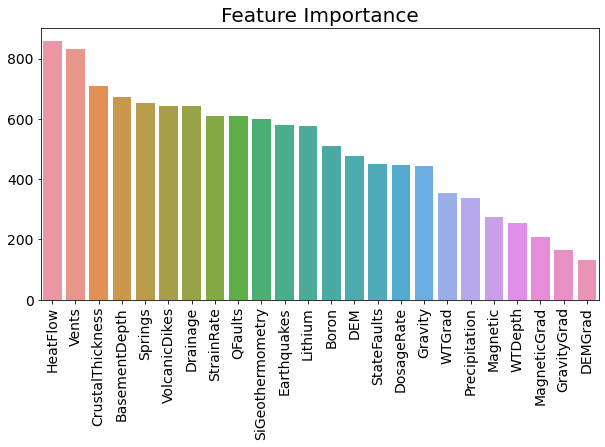

XGBClassifier(colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5,
              min_child_weight=3, n_estimators=200, n_jobs=-1,
              objective='multi:softprob', reg_lambda=1.2742749857031321,
              scale_pos_weight=1.0, seed=43, subsample=0.6)


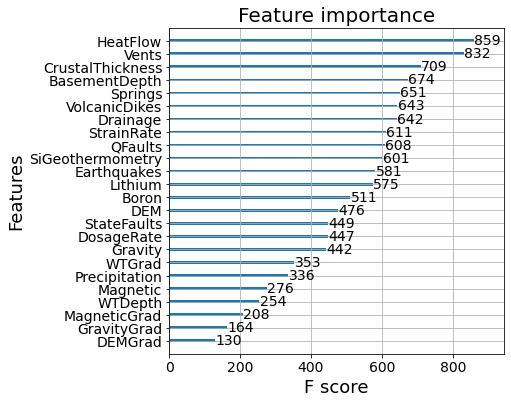

In [ ]:
# Incorporate tuning results
xgb_model6 = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=best_params['max_depth'], 
                          min_child_weight=best_params['min_child_weight'],
                          gamma=best_params['gamma'], 
                          subsample=best_params['subsample'], 
                          colsample_bytree=best_params['colsample_bytree'],
                          reg_lambda=best_params['reg_lambda'],
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

xgb_model6 = XGBfit(xgb_model6, 
                    Xtrsc, 
                    pd.Series(yenc_trn,name='GeothermGrad'), 
                    Xvlsc, 
                    pd.Series(yenc_val,name='GeothermGrad'), 
                    Xtssc, 
                    pd.Series(yenc_tst,name='GeothermGrad'), 
                    keepcols);
print(xgb_model6)

#### Tune on Scale Positive Weight

In [ ]:
# Tuning of scale_pos_weight
valrng = np.arange(0,1.1,.1)
params_gs9 = {
  'scale_pos_weight':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=best_params['max_depth'], 
                          min_child_weight=best_params['min_child_weight'],
                          gamma=best_params['gamma'], 
                          subsample=best_params['subsample'], 
                          colsample_bytree=best_params['colsample_bytree'],
                          reg_lambda=best_params['reg_lambda'],
                          scale_pos_weight=SPWT, 
                          objective='multi:softprob',
                          n_jobs=-1,
                          seed=seed)

gridcv9 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs9,
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose = 10,
                       cv=cv)

gridcv9 = gridcv9.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['scale_pos_weight'] = SPWT = gridcv9.best_params_['scale_pos_weight']

getTrainScores(gridcv9)

Fitting 30 folds for each of 11 candidates, totalling 330 fits


({0: "mean:0.9836333108215037params{'scale_pos_weight': 0.0}",
  1: "mean:0.9836333108215037params{'scale_pos_weight': 0.1}",
  2: "mean:0.9836333108215037params{'scale_pos_weight': 0.2}",
  3: "mean:0.9836333108215037params{'scale_pos_weight': 0.30000000000000004}",
  4: "mean:0.9836333108215037params{'scale_pos_weight': 0.4}",
  5: "mean:0.9836333108215037params{'scale_pos_weight': 0.5}",
  6: "mean:0.9836333108215037params{'scale_pos_weight': 0.6000000000000001}",
  7: "mean:0.9836333108215037params{'scale_pos_weight': 0.7000000000000001}",
  8: "mean:0.9836333108215037params{'scale_pos_weight': 0.8}",
  9: "mean:0.9836333108215037params{'scale_pos_weight': 0.9}",
  10: "mean:0.9836333108215037params{'scale_pos_weight': 1.0}"},
 {'best_mean': 0.9836333108215037, 'best_param': {'scale_pos_weight': 0.0}})

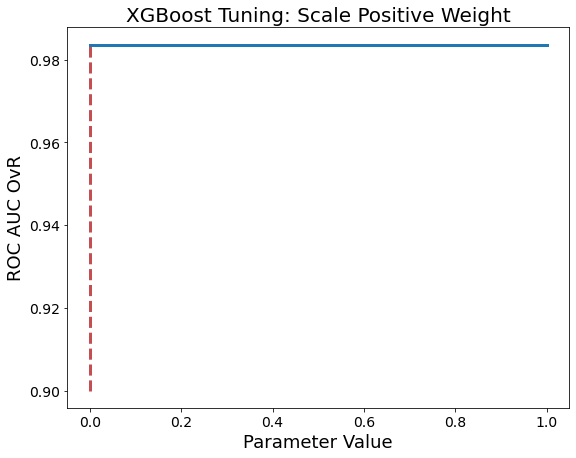

In [ ]:
cv = gridcv9

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',lw=3)
  plt.vlines(best_params['scale_pos_weight'],
             ymin=0.9,ymax=cv.best_score_,
             linestyles='dashed',colors='r',lw=3)
  plt.title('XGBoost Tuning: Scale Positive Weight');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

[0]	val-mlogloss:1.37621	val-merror:0.219731	train-mlogloss:1.37613	train-merror:0.222009
[100]	val-mlogloss:0.758236	val-merror:0.100897	train-mlogloss:0.734863	train-merror:0.082653
[199]	val-mlogloss:0.519107	val-merror:0.089686	train-mlogloss:0.480536	train-merror:0.058626

XGBFit Results
Accuracy (Train) : 0.9414
Accuracy (Test)  : 0.9058
F1-weighted (Train): 0.940534
F1-weighted (Test) : 0.904516
macro AUC (Train): 0.994591
weighted AUC (Train): 0.992755
macro AUC (Test) : 0.989919
weighted AUC (Test): 0.987971
[[ 11   4   0   0]
 [  0  59   9   7]
 [  0   5 156  11]
 [  0   0   6 178]]
              precision    recall  f1-score   support

       No-GT       1.00      0.73      0.85        15
      Low-GT       0.87      0.79      0.83        75
      Med-GT       0.91      0.91      0.91       172
     High-GT       0.91      0.97      0.94       184

    accuracy                           0.91       446
   macro avg       0.92      0.85      0.88       446
weighted avg       0

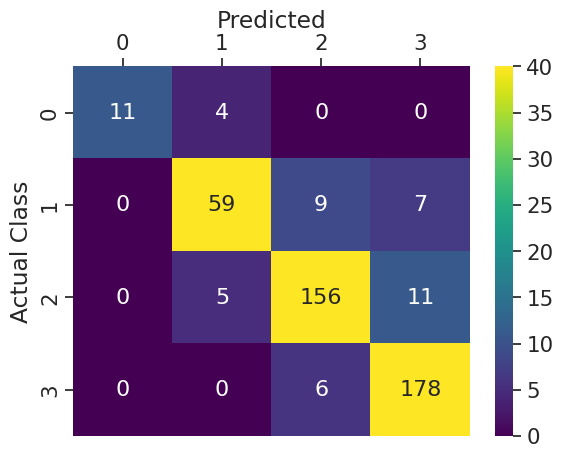

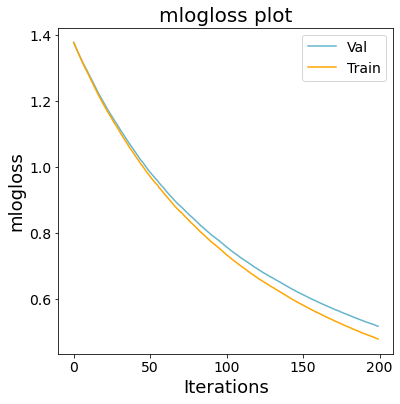

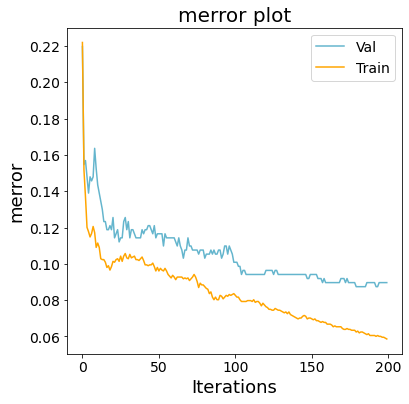

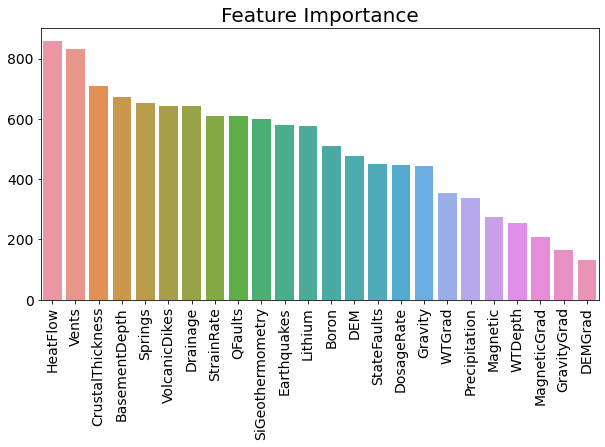

XGBClassifier(colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=5,
              min_child_weight=3, n_estimators=200, n_jobs=-1,
              objective='multi:softprob', reg_lambda=1.2742749857031321,
              scale_pos_weight=0.0, seed=43, subsample=0.6)


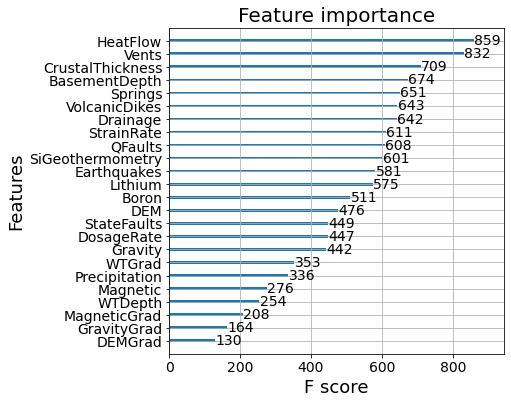

In [ ]:
# Incorporate tuning results
xgb_model7 = XGBClassifier(learning_rate=LR,
                            n_estimators=NEST,
                            max_depth=best_params['max_depth'], 
                            min_child_weight=best_params['min_child_weight'],
                            gamma=best_params['gamma'], 
                            subsample=best_params['subsample'], 
                            colsample_bytree=best_params['colsample_bytree'],
                            reg_lambda=best_params['reg_lambda'],
                            scale_pos_weight=best_params['scale_pos_weight'],
                            objective='multi:softprob',
                            n_jobs=-1,
                            seed=seed)
                          
xgb_model7 = XGBfit(xgb_model7,
                    Xtrsc,
                    pd.Series(yenc_trn,name='GeothermGrad'),
                    Xvlsc,
                    pd.Series(yenc_val,name='GeothermGrad'),
                    Xtssc,
                    pd.Series(yenc_tst,name='GeothermGrad'),
                    keepcols);
print(xgb_model7)

### NOTE: no difference with changing scale_pos_weight!

### Create final model and plot ROC curves

In [ ]:
RESET_BEST_PARAMS = True
VERSION = 4

if RESET_BEST_PARAMS:
  best_params = {}
  if VERSION == 4:
    best_params = {'max_depth': 5,
                  'min_child_weight': 3,
                  'gamma': 0.1,
                  'subsample': 0.6,
                  'colsample_bytree': 0.5,
                  'reg_lambda': 1.27,
                  'scale_pos_weight': 0.0,
                  'learning_rate':0.005,
                  'n_estimators':1000}
  elif VERSION == 8:
    best_params = {'max_depth': 4,
                  'min_child_weight': 3,
                  'gamma': 0.2,
                  'subsample': 0.5,
                  'colsample_bytree': 0.5,
                  'reg_lambda': 1.27,
                  'scale_pos_weight': 0.0,
                  'learning_rate':0.005,
                  'n_estimators':1750}
  else:
    best_params = {'max_depth': 5,
                  'min_child_weight': 7,
                  'gamma': 0.1,
                  'subsample': 0.5,
                  'colsample_bytree': 0.6,
                  'reg_lambda': 1.27,
                  'scale_pos_weight': 0.0,
                  'learning_rate':0.005,
                  'n_estimators':1000}   
else:
  best_params['n_estimators'] = NEST = 1000
  best_params['learning_rate'] = LR = 0.005

best_params

{'colsample_bytree': 0.5,
 'gamma': 0.1,
 'learning_rate': 0.005,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 1000,
 'reg_lambda': 1.2742749857031321,
 'scale_pos_weight': 0.0,
 'subsample': 0.6}

[0]	val-mlogloss:1.38124	val-merror:0.219731	train-mlogloss:1.3812	train-merror:0.222009
[100]	val-mlogloss:0.989777	val-merror:0.109865	train-mlogloss:0.976657	train-merror:0.095147
[200]	val-mlogloss:0.763692	val-merror:0.100897	train-mlogloss:0.740857	train-merror:0.083133
[300]	val-mlogloss:0.617604	val-merror:0.09417	train-mlogloss:0.587022	train-merror:0.070639
[400]	val-mlogloss:0.519351	val-merror:0.085202	train-mlogloss:0.481412	train-merror:0.057665
[500]	val-mlogloss:0.449695	val-merror:0.08296	train-mlogloss:0.406736	train-merror:0.048054
[600]	val-mlogloss:0.395971	val-merror:0.080717	train-mlogloss:0.347835	train-merror:0.042768
[700]	val-mlogloss:0.355814	val-merror:0.073991	train-mlogloss:0.302983	train-merror:0.037001
[800]	val-mlogloss:0.323479	val-merror:0.065022	train-mlogloss:0.266718	train-merror:0.030754
[900]	val-mlogloss:0.297469	val-merror:0.06278	train-mlogloss:0.236995	train-merror:0.02691
[999]	val-mlogloss:0.275673	val-merror:0.060538	train-mlogloss:0.2118

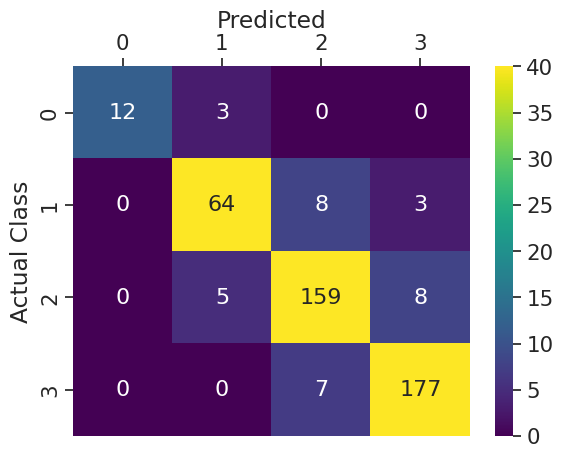

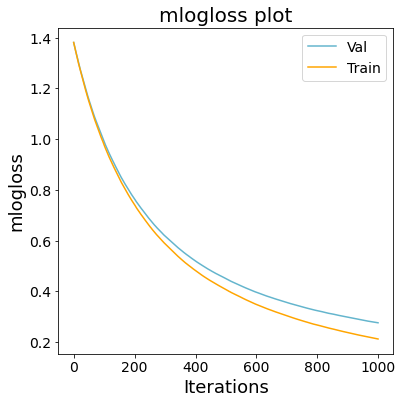

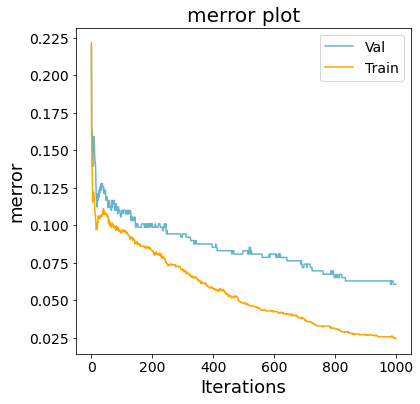

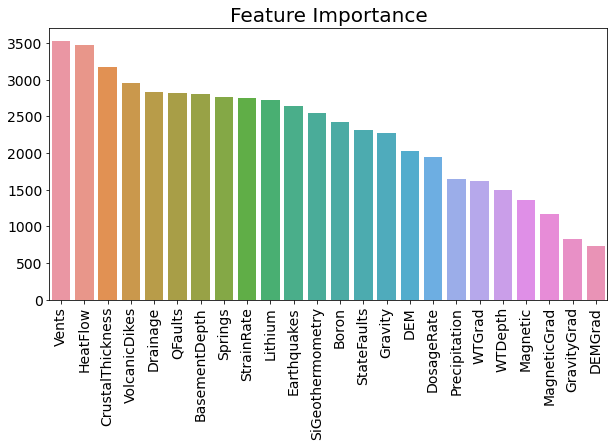

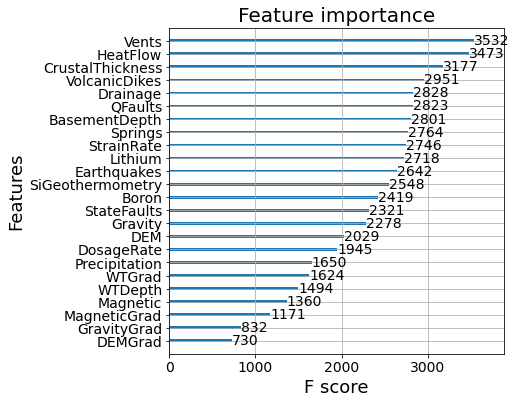

In [ ]:
xgb_model_fin = XGBClassifier(learning_rate=best_params['learning_rate'],
                              n_estimators=best_params['n_estimators'],
                              max_depth=best_params['max_depth'], 
                              min_child_weight=best_params['min_child_weight'],
                              gamma=best_params['gamma'], 
                              subsample=best_params['subsample'], 
                              colsample_bytree=best_params['colsample_bytree'],
                              reg_lambda=best_params['reg_lambda'],
                              scale_pos_weight=best_params['scale_pos_weight'],
                              objective='multi:softprob',
                              n_jobs=-1,
                              seed=seed)

xgb_model_fin = XGBfit(xgb_model_fin,
                       Xtrsc,
                       pd.Series(yenc_trn,name='GeothermGrad'),
                       Xvlsc,
                       pd.Series(yenc_val,name='GeothermGrad'),
                       Xtssc,
                       pd.Series(yenc_tst,name='GeothermGrad'),
                       colnames, savefig=True);

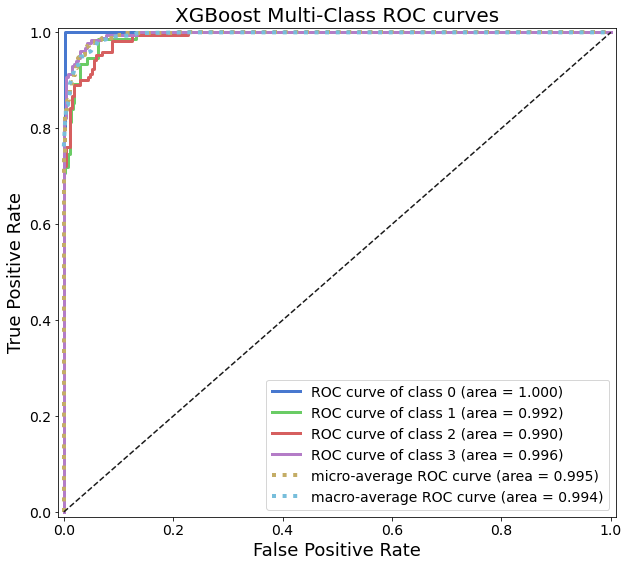

In [ ]:
## from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#area-under-roc-for-the-multiclass-problem
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import matplotlib as mpl

predprobs_test = xgb_model_fin.predict_proba(Xtssc[colnames])
preds_test     = np.argmax(predprobs_test, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes=[0,1,2,3]
n_classes = len(classes)
yt_bin = label_binarize(yenc_tst, classes=classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yt_bin[:,i], predprobs_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yt_bin.ravel(), predprobs_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(yt_bin.ravel(), predprobs_test.ravel())
#roc_auc['micro'] = metrics.roc_auc_score(yenc_tst, predprobs_test, average='micro',multi_class='ovr')
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = metrics.roc_auc_score(yenc_tst, predprobs_test, average='macro',multi_class='ovr')
#roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 3
with mpl.style.context("seaborn-muted"):
  plt.figure(figsize=(10,9))

  colors = cycle(['#4A67BF','#8C8C8C','#73A96C','#AD5153'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], lw=lw,   #color=color,lw=lw,alpha=.5,
              label='ROC curve of class {0} (area = {1:0.3f})'
              ''.format(i, roc_auc[i]))

  plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.3f})'
                  ''.format(roc_auc["micro"]),
            linestyle=':', lw=(lw+1))  #color='#C98AC1',alpha=.5

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["macro"]),
           linestyle=':', lw=(lw+1))  #color='#82B3CC', lw=lw,alpha=.5
           
  plt.plot([0, 1], [0, 1], 'k--') #, lw=lw, alpha=0.5
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('XGBoost Multi-Class ROC curves')
  plt.legend(loc="lower right")
  plt.savefig(datafolder / 'XGBoost_WDS4_ROCplot.png', bbox_inches='tight')
  plt.show()

#### Grab some stats

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

xgb_model_fin.fit(Xtrsc,yenc_trn)

print('Training accuracy: {}'.format(accuracy_score(yenc_trn,xgb_model_fin.predict(Xtrsc))))
print('Testing accuracy: {}'.format(accuracy_score(yenc_tst,xgb_model_fin.predict(Xtssc))))

roctrn = roc_auc_score(yenc_trn, xgb_model_fin.predict_proba(Xtrsc), multi_class='ovr')
print('AUC train: {}'.format(roctrn))
  
roctest = roc_auc_score(yenc_tst, xgb_model_fin.predict_proba(Xtssc), multi_class='ovr')
print('AUC test: {}'.format(roctest))
print(best_params)

Training accuracy: 0.9759730898606439
Testing accuracy: 0.9237668161434978
AUC train: 0.9983317690326863
AUC test: 0.9942981671863997
{'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.5, 'reg_lambda': 1.2742749857031321, 'scale_pos_weight': 0.0, 'learning_rate': 0.005, 'n_estimators': 1000}


## Load full dataset and predict

In [ ]:
# load full map dataset
with open(datafolder/ "full_shared.pkl","rb") as handle: 
    datadict = pkl.load(handle)
    
# unpack
FULLdf     = datadict['data']
FULLcoords = datadict['coords']

pfa_result = FULLdf['GeothermGrad_4class']
FULLdf = FULLdf[colnames]
FULLdfsc = pd.DataFrame(pl.transform(FULLdf), columns=colnames)

# use all data
Xallsc = pd.concat([Xtrsc[colnames],Xvlsc[colnames],Xtssc[colnames]])
yenc_all=np.append(np.append(yenc_trn,yenc_val),yenc_tst)

#### train on all data for final predictive model

In [ ]:
xgb_model_fin = XGBClassifier(learning_rate=best_params['learning_rate'],
                              n_estimators=best_params['n_estimators'],
                              max_depth=best_params['max_depth'], 
                              min_child_weight=best_params['min_child_weight'],
                              gamma=best_params['gamma'], 
                              subsample=best_params['subsample'], 
                              colsample_bytree=best_params['colsample_bytree'],
                              reg_lambda=best_params['reg_lambda'],
                              scale_pos_weight=best_params['scale_pos_weight'],
                              objective='multi:softprob',
                              n_jobs=-1,
                              seed=seed)
xgb_model_fin = xgb_model_fin.fit(Xallsc, yenc_all)

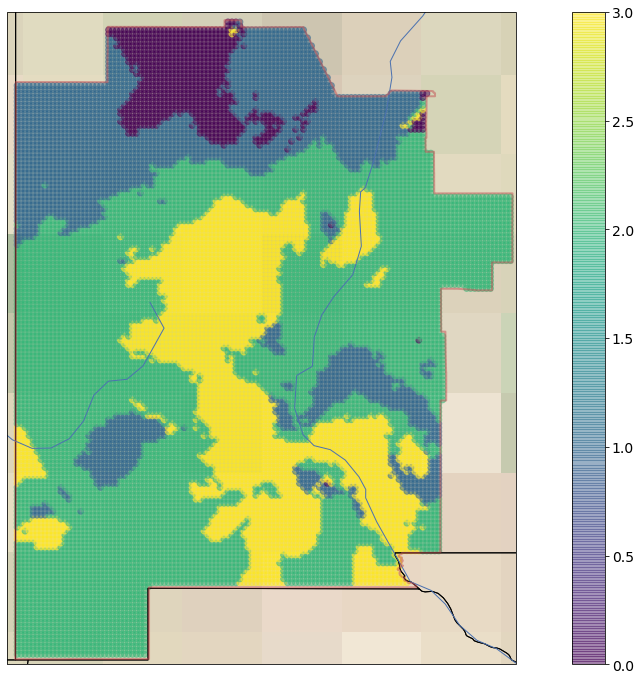

In [ ]:
# predict result
FULL_ypred = xgb_model_fin.predict(FULLdfsc)
FULL_ypred_proba = xgb_model_fin.predict_proba(FULLdfsc)

# plot result
ax = createBasemap();
gdf = gpd.GeoDataFrame(FULLcoords, 
                       geometry=gpd.points_from_xy(FULLcoords.Longitude, FULLcoords.Latitude),
                       crs = {'init': 'epsg:4326'})
pc = ax.scatter(FULLcoords.Longitude,
                FULLcoords.Latitude,
                cmap='viridis',
                c=FULL_ypred,
                alpha=0.5,
                transform=myprojection);
plt.colorbar(pc);
plt.savefig(datafolder / 'xgboost_model_prediction_map.png', bbox_inches='tight')
plt.savefig(datafolder / 'xgboost_model_prediction_map.pdf', bbox_inches='tight')

### Save model and results for ALL features

In [ ]:
outname = datafolder / 'xgb_model_fin_allfeat.json'
xgb_model_fin.save_model(str(outname))

# save out for use in other scripts
shared = {
          "coords":FULLcoords,
          "model":xgb_model_fin,
          "full_dataset":FULLdf,
          "selected_columns":colnames,
          "test_yc_pred":preds_test,
          "test_yc_pred_proba":predprobs_test,
          "full_yc_pred":FULL_ypred,
          "full_yc_pred_proba":FULL_ypred_proba
         }
with open(datafolder / "gradient_class_prediction_xgb.pkl","wb") as handle:
    pkl.dump(shared, handle, protocol=pkl.HIGHEST_PROTOCOL)


## Shapley results
####https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/
####https://medium.com/dataman-in-ai/the-shap-with-more-elegant-charts-bc3e73fa1c0c

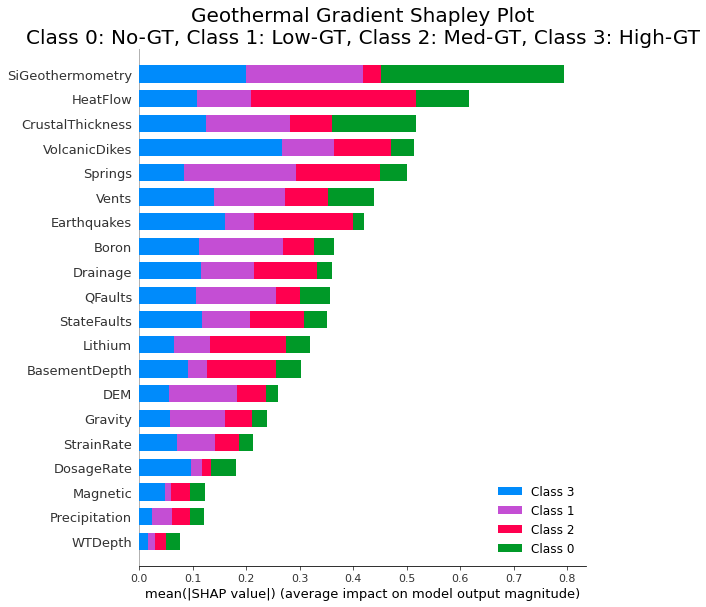

In [ ]:
explainer = shap.TreeExplainer(xgb_model_fin)
shap_values = explainer.shap_values(Xtssc ,check_additivity=True)
plt.title('Geothermal Gradient Shapley Plot'+'\n'+'Class 0: No-GT, Class 1: Low-GT, Class 2: Med-GT, Class 3: High-GT')
f = shap.summary_plot(shap_values, Xtssc, plot_type="bar",show=False)
plt.savefig(datafolder / 'xgb_shapley.png', bbox_inches='tight')
plt.show()

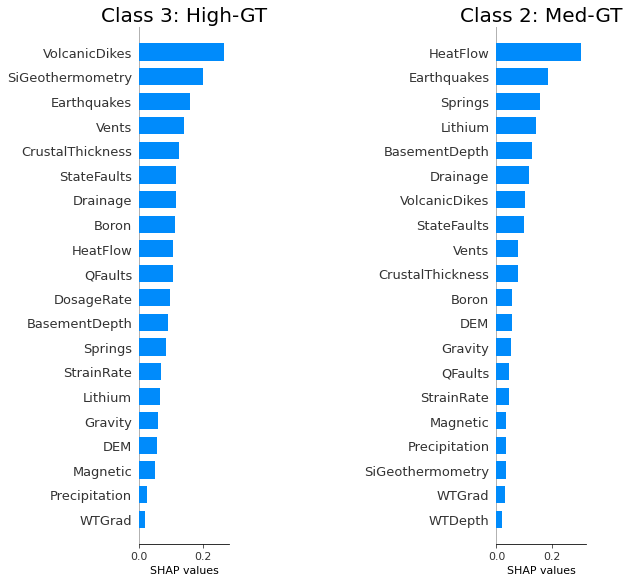

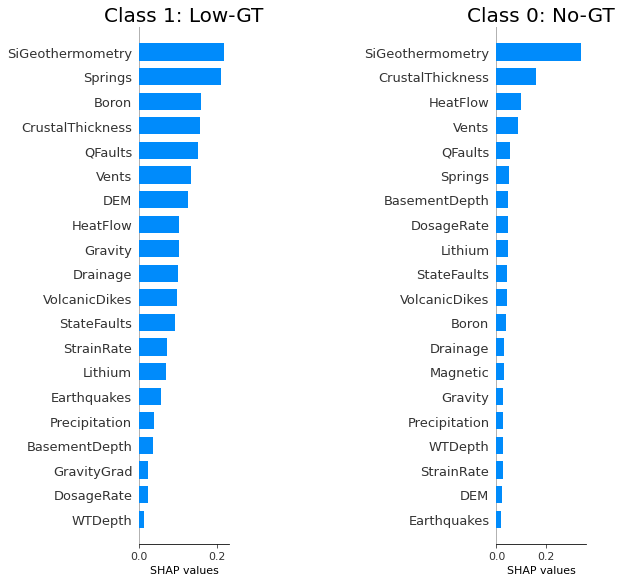

In [ ]:
fig = plt.figure(figsize=(30,10))

ax0 = fig.add_subplot(121)
ax0.title.set_text('Class 3: High-GT')
shap.summary_plot(shap_values[3], Xtssc[colnames], plot_type="bar", show=False)
ax0.set_xlabel(r'SHAP values', fontsize=11)
plt.subplots_adjust(wspace = 3)

ax1 = fig.add_subplot(122)
ax1.title.set_text('Class 2: Med-GT')
shap.summary_plot(shap_values[2], Xtssc[colnames], plot_type="bar", show=False)
ax1.set_xlabel(r'SHAP values', fontsize=11)
plt.savefig(datafolder / 'xgb_shapley_classplots1.png', bbox_inches='tight')

fig = plt.figure(figsize=(30,10))

ax2 = fig.add_subplot(121)
ax2.title.set_text('Class 1: Low-GT')
shap.summary_plot(shap_values[1], Xtssc[colnames], plot_type="bar", show=False)
ax2.set_xlabel(r'SHAP values', fontsize=11)
plt.subplots_adjust(wspace = 3)

ax3 = fig.add_subplot(122)
ax3.title.set_text('Class 0: No-GT')
shap.summary_plot(shap_values[0], Xtssc[colnames], plot_type="bar", show=False)
ax3.set_xlabel(r'SHAP values', fontsize=11)

plt.savefig(datafolder / 'xgb_shapley_classplots2.png', bbox_inches='tight')
#plt.tight_layout(pad=4) # You can also use plt.tight_layout() instead of using plt.subplots_adjust() to add space between plots
plt.show()

## Drop Low-Importance Features

In [ ]:
shap_dropcols = ['DosageRate','Precipitation','Magnetic','WTGrad','WTDepth', 'DEMGrad','GravityGrad','MagneticGrad']
fs_keepcols = [f for f in Xtrsc.columns if f not in shap_dropcols]
fs_keepcols
#fs_keepcols = ['SiGeothermometry','HeatFlow','CrustalThickness','VolcanicDikes','Springs','Earthquakes','Vents','Boron','QFaults','Drainage','Lithium','BasementDepth','StateFaults','StrainRate','Gravity','DEM']

['DEM',
 'Gravity',
 'BasementDepth',
 'CrustalThickness',
 'StrainRate',
 'QFaults',
 'StateFaults',
 'Drainage',
 'VolcanicDikes',
 'SiGeothermometry',
 'Lithium',
 'Boron',
 'HeatFlow',
 'Earthquakes',
 'Vents',
 'Springs']

[0]	val-mlogloss:1.38072	val-merror:0.215247	train-mlogloss:1.38099	train-merror:0.2321
[100]	val-mlogloss:0.988847	val-merror:0.107623	train-mlogloss:0.977729	train-merror:0.100432
[200]	val-mlogloss:0.764118	val-merror:0.105381	train-mlogloss:0.743712	train-merror:0.088419
[300]	val-mlogloss:0.617987	val-merror:0.100897	train-mlogloss:0.589278	train-merror:0.074964
[400]	val-mlogloss:0.519392	val-merror:0.089686	train-mlogloss:0.484236	train-merror:0.064873
[500]	val-mlogloss:0.448477	val-merror:0.085202	train-mlogloss:0.408622	train-merror:0.057665
[600]	val-mlogloss:0.395575	val-merror:0.071749	train-mlogloss:0.350943	train-merror:0.047093
[700]	val-mlogloss:0.354402	val-merror:0.071749	train-mlogloss:0.305973	train-merror:0.040365
[800]	val-mlogloss:0.322786	val-merror:0.067265	train-mlogloss:0.270907	train-merror:0.034599
[900]	val-mlogloss:0.296678	val-merror:0.06278	train-mlogloss:0.241841	train-merror:0.030754
[999]	val-mlogloss:0.275412	val-merror:0.058296	train-mlogloss:0.21

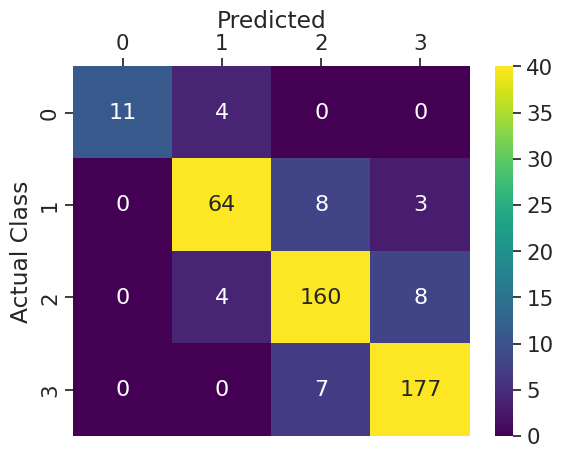

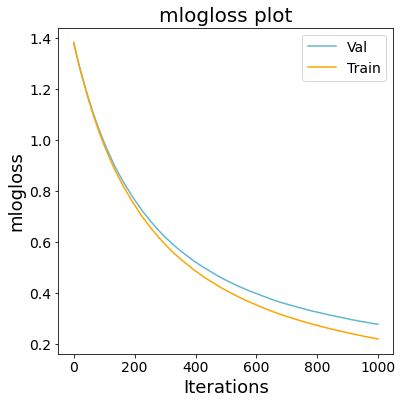

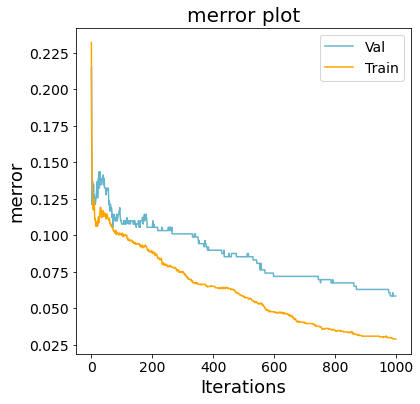

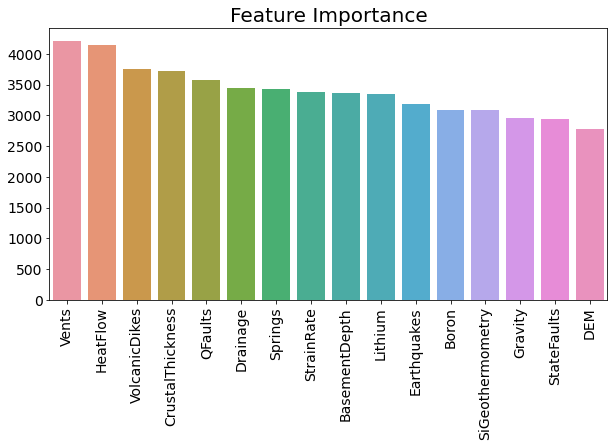

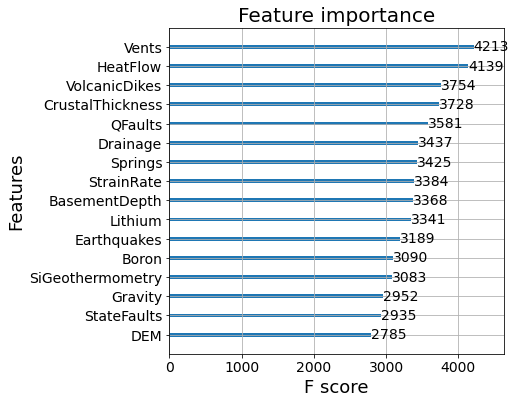

In [ ]:
xgb_model_fin16 = XGBClassifier(learning_rate=best_params['learning_rate'],
                                n_estimators=best_params['n_estimators'],
                                max_depth=best_params['max_depth'], 
                                min_child_weight=best_params['min_child_weight'],
                                gamma=best_params['gamma'], 
                                subsample=best_params['subsample'], 
                                colsample_bytree=best_params['colsample_bytree'],
                                reg_lambda=best_params['reg_lambda'],
                                scale_pos_weight=best_params['scale_pos_weight'],
                                objective='multi:softprob',
                                n_jobs=-1,
                                seed=seed)

xgb_model_fin16 = XGBfit(xgb_model_fin16,
                          Xtrsc[fs_keepcols],
                          pd.Series(yenc_trn,name='GeothermGrad'),
                          Xvlsc[fs_keepcols],
                          pd.Series(yenc_val,name='GeothermGrad'),
                          Xtssc[fs_keepcols],
                          pd.Series(yenc_tst,name='GeothermGrad'),
                          fs_keepcols);

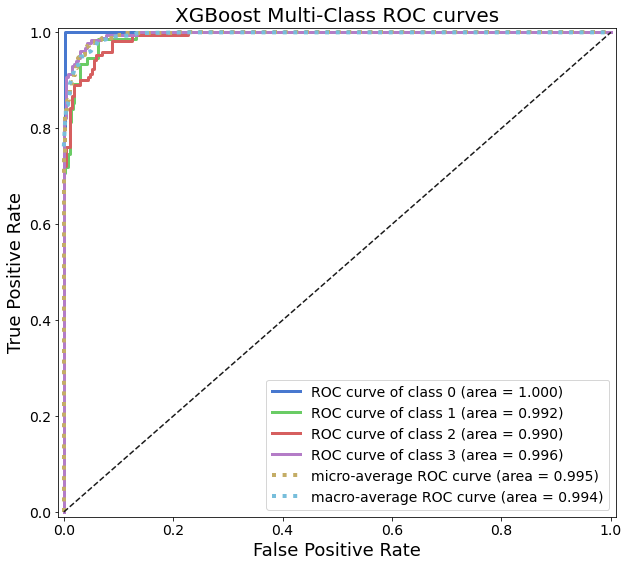

In [ ]:
## from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#area-under-roc-for-the-multiclass-problem
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import matplotlib as mpl

predprobs_test16 = xgb_model_fin16.predict_proba(Xtssc[fs_keepcols])
preds_test16     = np.argmax(predprobs_test, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes=[0,1,2,3]
n_classes = len(classes)
yt_bin = label_binarize(yenc_tst, classes=classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yt_bin[:,i], predprobs_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yt_bin.ravel(), predprobs_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(yt_bin.ravel(), predprobs_test.ravel())
#roc_auc['micro'] = metrics.roc_auc_score(yenc_tst, predprobs_test, average='micro',multi_class='ovr')
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = metrics.roc_auc_score(yenc_tst, predprobs_test, average='macro',multi_class='ovr')
#roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 3
with mpl.style.context("seaborn-muted"):
  plt.figure(figsize=(10,9))

  colors = cycle(['#4A67BF','#8C8C8C','#73A96C','#AD5153'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], lw=lw,   #color=color,lw=lw,alpha=.5,
              label='ROC curve of class {0} (area = {1:0.3f})'
              ''.format(i, roc_auc[i]))

  plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.3f})'
                  ''.format(roc_auc["micro"]),
            linestyle=':', lw=(lw+1))  #color='#C98AC1',alpha=.5

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["macro"]),
           linestyle=':', lw=(lw+1))  #color='#82B3CC', lw=lw,alpha=.5
           
  plt.plot([0, 1], [0, 1], 'k--') #, lw=lw, alpha=0.5
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('XGBoost Multi-Class ROC curves')
  plt.legend(loc="lower right")
  plt.savefig(datafolder / 'XGBoost16_WDS4_ROCplot.png', bbox_inches='tight')
  plt.show()

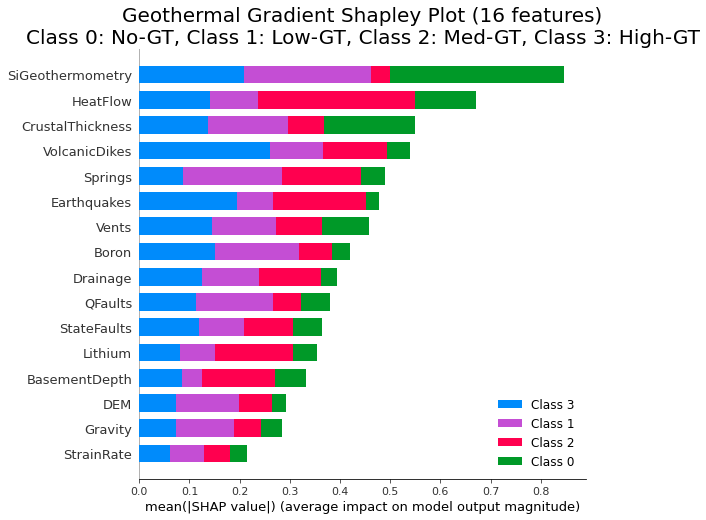

In [ ]:
explainer = shap.TreeExplainer(xgb_model_fin16)
shap_values = explainer.shap_values(Xtssc[fs_keepcols],check_additivity=True)
plt.title('Geothermal Gradient Shapley Plot (16 features)'+'\n'+'Class 0: No-GT, Class 1: Low-GT, Class 2: Med-GT, Class 3: High-GT')
f = shap.summary_plot(shap_values, Xtssc[fs_keepcols], plot_type="bar",show=False)
plt.savefig(datafolder / 'xgb16_shapley.png', bbox_inches='tight')
plt.show()

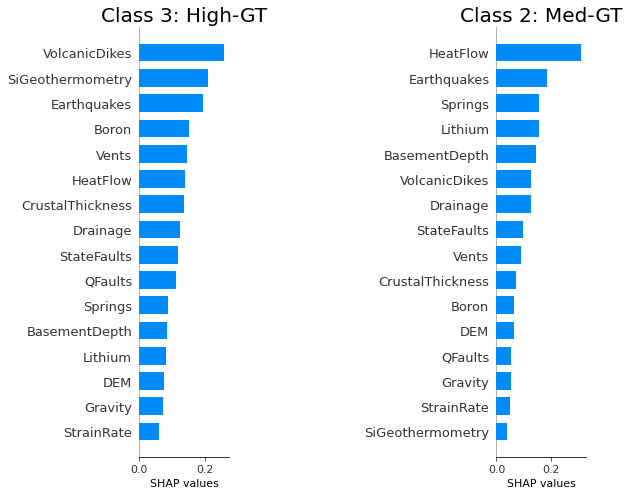

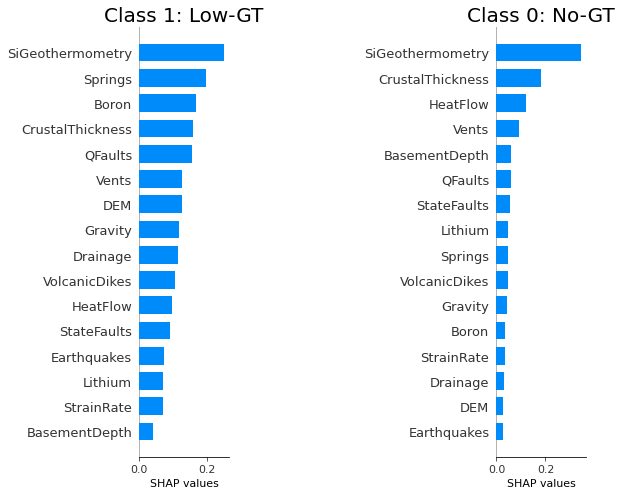

In [ ]:
fig = plt.figure(figsize=(30,10))

ax0 = fig.add_subplot(121)
ax0.title.set_text('Class 3: High-GT')
shap.summary_plot(shap_values[3], Xtssc[fs_keepcols], plot_type="bar", show=False)
ax0.set_xlabel(r'SHAP values', fontsize=11)
plt.subplots_adjust(wspace = 3)

ax1 = fig.add_subplot(122)
ax1.title.set_text('Class 2: Med-GT')
shap.summary_plot(shap_values[2], Xtssc[fs_keepcols], plot_type="bar", show=False)
ax1.set_xlabel(r'SHAP values', fontsize=11)
plt.savefig(datafolder / 'xgb16_shapley_classplots1.png', bbox_inches='tight')

fig = plt.figure(figsize=(30,10))

ax2 = fig.add_subplot(121)
ax2.title.set_text('Class 1: Low-GT')
shap.summary_plot(shap_values[1], Xtssc[fs_keepcols], plot_type="bar", show=False)
ax2.set_xlabel(r'SHAP values', fontsize=11)
plt.subplots_adjust(wspace = 3)

ax3 = fig.add_subplot(122)
ax3.title.set_text('Class 0: No-GT')
shap.summary_plot(shap_values[0], Xtssc[fs_keepcols], plot_type="bar", show=False)
ax3.set_xlabel(r'SHAP values', fontsize=11)

plt.savefig(datafolder / 'xgb16_shapley_classplots2.png', bbox_inches='tight')
#plt.tight_layout(pad=4) # You can also use plt.tight_layout() instead of using plt.subplots_adjust() to add space between plots
plt.show()

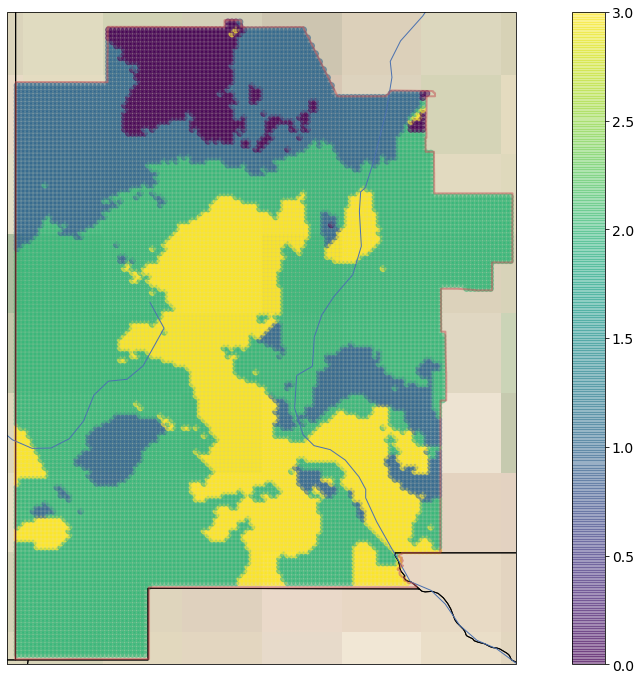

In [ ]:
xgb_model_fin16 = XGBClassifier(learning_rate=best_params['learning_rate'],
                                n_estimators=best_params['n_estimators'],
                                max_depth=best_params['max_depth'], 
                                min_child_weight=best_params['min_child_weight'],
                                gamma=best_params['gamma'], 
                                subsample=best_params['subsample'], 
                                colsample_bytree=best_params['colsample_bytree'],
                                reg_lambda=best_params['reg_lambda'],
                                scale_pos_weight=best_params['scale_pos_weight'],
                                objective='multi:softprob',
                                n_jobs=-1,
                                seed=seed)
xgb_model_fin16 = xgb_model_fin.fit(Xallsc[fs_keepcols], yenc_all)

# predict result
FULL_ypred16 = xgb_model_fin16.predict(FULLdfsc[fs_keepcols])
FULL_ypred_proba16 = xgb_model_fin16.predict_proba(FULLdfsc[fs_keepcols])

# plot result
ax = createBasemap();
gdf = gpd.GeoDataFrame(FULLcoords, 
                       geometry=gpd.points_from_xy(FULLcoords.Longitude, FULLcoords.Latitude),
                       crs = {'init': 'epsg:4326'})
pc = ax.scatter(FULLcoords.Longitude,
                FULLcoords.Latitude,
                cmap='viridis',
                c=FULL_ypred16,
                alpha=0.5,
                transform=myprojection);
plt.colorbar(pc);
plt.savefig(datafolder / 'xgboost16_model_prediction_map.png', bbox_inches='tight')
plt.savefig(datafolder / 'xgboost16_model_prediction_map.pdf', bbox_inches='tight')

## Save out final XGB model

In [ ]:
outname = datafolder / 'xgb_model_fin_16feat.json'
xgb_model_fin16.save_model(str(outname))

In [ ]:
predprobs_test16 = xgb_model_fin16.predict_proba(Xtssc[fs_keepcols])
preds_test16     = np.argmax(predprobs_test, axis=1)

# save out for use in other scripts
shared = {
          "coords":FULLcoords,
          "model":xgb_model_fin16,
          "full_dataset":FULLdf,
          "selected_columns":fs_keepcols,
          "test_yc_pred":preds_test16,
          "test_yc_pred_proba":predprobs_test16,
          "full_yc_pred":FULL_ypred16,
          "full_yc_pred_proba":FULL_ypred_proba16
         }
with open(datafolder / "gradient_class_prediction_xgb16.pkl","wb") as handle:
    pkl.dump(shared, handle, protocol=pkl.HIGHEST_PROTOCOL)
